In [8]:
# load some packages

from pyproj import Proj, transform
import utm
from osgeo import gdal

from zipfile import ZipFile
import xml.sax, xml.sax.handler

import glob, os

import simplekml
from simplekml import Kml, Color

import xarray as xr
import pickle
import pandas as pd

from shapely.geometry import Polygon, LineString

from skimage import filters
from skimage.morphology import disk

from scipy.ndimage.filters import minimum_filter, maximum_filter
from scipy.signal import medfilt2d, argrelextrema, detrend
import numpy as np
from scipy.spatial.distance import cdist

from copy import copy
from matplotlib import pyplot as plt
from matplotlib import colors as pltcolors
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

In [2]:
# define a kernel density function that can deal with weighted data
# this is from https://stackoverflow.com/questions/27623919/weighted-gaussian-kernel-density-estimation-in-python

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

In [3]:
###############
## FUNCTION DEFS TO PARSE KMZ ##
###############

class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""
        
def build_table(mapping):
    sep = ','
        
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
        
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [4]:
###############
## FUNCTION DEFS TO FIND DUNE FIELD AREA ##
###############

def polygonArea(vertups):
    X = vertups[:,0]
    Y = vertups[:,1]
    n = len(X) 
    # Initialze area 
    area = 0.0
    # Calculate value of shoelace formula 
    j = n - 1
    for i in range(0,n): 
        area += (X[j] + X[i]) * (Y[j] - Y[i]) 
        j = i   # j is previous vertex to i 
    # Return absolute value 
    return abs(area / 2.0)

In [397]:
###############
## FUNCTION DEFS TO FIND SAND FLUX AND DUNE ORIENTATION ##
###############

# representative constants
rhos = 2650 # quartz
rhof = 1.225 # air
grav = 9.81 # gravity
gdia = 300e-6 # aeolian grain diameter
kapp = 0.41 # von karman
z0rf = 1e-3 # roughness length
zU   = 10 # height of ERA5 wind vectors
gamm = 1 # fitting parameter from narteau papers
T = np.linspace(0,np.pi,360) # theta direction options

def flux(U,gdia): # gives you the volume flux scalar given wind speeds and grain diameter (not summed over time)
    uscr = (rhos*grav*gdia/rhof)**0.5/10 # iverson et al 1987   
    usabs = U*kapp/np.log(zU/z0rf) # neutral law of the wall
    usabs[usabs<uscr] = uscr # get rid of negative unreal data
    return 25*rhof/rhos*(gdia/grav)**0.5*(usabs**2-uscr**2) # duran et al 2011

def duneangles(Q,A): # gives you the dune orientation for the flux vectors from courrech du pont et al 2014
    t,q = np.meshgrid(T,Q)
    t,a = np.meshgrid(T,A)
    # returns the curves for the bed instability then the finger instability
    # then to find the angle you must find the max of the first and the root of the second
    return np.sum(q*(np.abs(np.sin(t-a))+gamm*np.sin(t-a)**2),axis=0), np.sum(q*(1+gamm*np.abs(np.sin(t-a)))*np.sin(t-a),axis=0) #courrech du pont et al 2014 
    

In [6]:
# changes of convention for direction
def arctan2_to_bearingfromN(A):
    return np.where((A>-np.pi)&(A<=np.pi/2),-A + np.pi/2,-A + np.pi/2 + 2*np.pi)

def bearingfromN_to_windrose(A):
    return np.where((A>=0)&(A<=3*np.pi/2),-A + 3*np.pi/2,-A + 3*np.pi/2 + 2*np.pi)

In [338]:
# some variables for wind roses
resA = 180
resU = 6
ubins = np.linspace(0,10,resU)
Ucr = 6
ucrbins = np.linspace(Ucr,2*Ucr,resU)
mA = (np.linspace(0,2*np.pi,resA+1))

In [339]:
# find all the ERA5 tiles on the dune fields
# this was done manually in google earth and information stored in a text file
# empty rows in the text file delineate seperate dune fields

text_file = open('/media/synology2/WANDS/ERA5/era_dune_tiles.txt', 'r')
lines = text_file.readlines()
text_file.close()

ondunes = []
ondune = [0]
for i in lines:
    # some lines of the text file are ranges in tile in N-S columns
    # example 130:135 means tiles 130 through 135 (inclusive)
    if ':' in i:
        start = i.split(':')[0]
        end   = i.split(':')[1]
        end   = end[:-1]
        ondune = np.append(ondune,np.arange(int(start),int(end)+1))
    # empty line implies new dune field below
    elif '\n'==i:
        ondunes.append(ondune[1:])
        ondune = [0]
    else:
        ondune = np.append(ondune,np.asarray(int(i[:-1])))

# long list of all ERA5 dune field tiles, not seperated by field, useful for iteration
Ondunes = np.concatenate(ondunes)

In [340]:
# here find all the dune field maps
# area is not well defined by counting ERA5 tiles within dune fields
# so i drew approximate boundaries of each in google earth
# the information is stored in a .kmz 

# parse the kmz
kmz = ZipFile('/media/synology2/WANDS/ERA5/dunefields.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# loop through dune fields
for i in np.arange(0,np.shape(list(handler.mapping))[0]):
    coords = handler.mapping[list(handler.mapping)[i]]["coordinates"]
    my_list = coords.split(",")

    # restructure string of coordinates into a useful array
    verts = my_list[:-1]
    vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
    for j in np.arange(0,np.shape(verts)[0]):
        # deal with janky save structure of .kmz
        verts[j]=verts[j].replace('0 ','')
        verts[j]=verts[j].replace('0-','-')
        if j%2==0:
            vertsclean[int(j/2),0] = verts[j]
        else:
            vertsclean[int(j/2),1] = verts[j]
    # now have a coordinate array for the points of the boundary of each dune field
    vertups = np.asarray(vertsclean)

    # save each as a pickle
    with open('/media/synology2/WANDS/ERA5/dunefields/df%d_verts.pkl'%i, 'wb') as f:
        pickle.dump(vertups, f)

In [341]:
# here just reload all the dune field boundary coords into a list
df_verts = []
for i in np.arange(0,np.shape(list(handler.mapping))[0]):
    with open('/media/synology2/WANDS/ERA5/dunefields/df%d_verts.pkl'%i, 'rb') as f:
        df_verts.append(pickle.load(f))

In [342]:
##################
# TURNS VERTEX TUPLES INTO FIELD AREA
##################
    
duneareas  = np.empty([np.shape(df_verts)[0]])
duneavlats = np.empty([np.shape(df_verts)[0]])
duneavlons = np.empty([np.shape(df_verts)[0]])
dunepolys  = []

# loop through dune fields
for i in np.arange(0,np.shape(df_verts)[0]):

    duneareas[i] = 0
        
    vertups = df_verts[i]

    #find median UTM of the lat-lon coordinates for the vertices
    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    # transform the latlon to xy using the UTM above
    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])

    # use shoelace formula to get the polygon area in km^2
    duneareas[i] = polygonArea(XY.T)/10**6
    # store the shape of the dune fields for figures maybe
    dunepolys.append(Polygon(XY.T))
    
    #store the centre coordinates for figures maybe
    duneavlats[i] = np.mean(vertups[:,1])
    duneavlons[i] = np.mean(vertups[:,0])

In [398]:
# this cell reproduces the data in supplementary figures 2 and 3 of courrech du pont et al 2014
# to ensure the algorithm is correct

N = 360

w10 = np.asarray([0,0,0,0,0])
W10 = np.tile(w10,(N,1))

w20 = np.linspace(0,np.pi,N)
W20 = np.tile(w20,(5,1)).T

w21 = np.linspace(0,np.pi,N)
W21 = np.tile(w20,(2,1)).T

w22 = np.linspace(0,np.pi,N)
W22 = np.tile(w20,(1,1)).T

W1020 = np.hstack((W10,W20))
W1021 = np.hstack((W10,W21))
W1022 = np.hstack((W10,W22))

S1020 = np.ones_like(W1020)*10
S1021 = np.ones_like(W1021)*10
S1022 = np.ones_like(W1022)*10

Tb1020 = np.empty(N)
Tf1020 = np.empty(N)
Tb1021 = np.empty(N)
Tf1021 = np.empty(N)
Tb1022 = np.empty(N)
Tf1022 = np.empty(N)

# loop through angles
for i in np.arange(0,N):
    bedmode,finmode = duneangles(flux(S1020[i,:],gdia),W1020[i,:])
    Tb1020[i] = T[np.argmax(bedmode)]
    Tf1020[i] = T[np.argmin((np.abs(finmode-0)))]

    bedmode,finmode = duneangles(flux(S1021[i,:],gdia),W1021[i,:])
    Tb1021[i] = T[np.argmax(bedmode)]
    Tf1021[i] = T[np.argmin((np.abs(finmode-0)))]
    
    bedmode,finmode = duneangles(flux(S1022[i,:],gdia),W1022[i,:])
    Tb1022[i] = T[np.argmax(bedmode)]
    Tf1022[i] = T[np.argmin((np.abs(finmode-0)))]

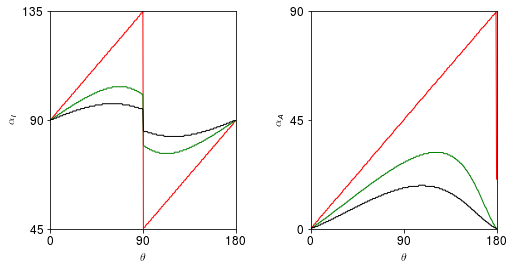

In [399]:
# this cell reproduces supplementary figures 2 and 3 of courrech du pont et al 2014
# to ensure the algorithm is correct

fs = 12
S = 10
LW = 1

fig = plt.gcf()

ax2 = plt.subplot(121)

sc1 = ax2.plot(w20*180/np.pi,Tb1020*180/np.pi,'r',lw=LW)
sc1 = ax2.plot(w21*180/np.pi,Tb1021*180/np.pi,'g',lw=LW)
sc1 = ax2.plot(w22*180/np.pi,Tb1022*180/np.pi,'k',lw=LW)

ax2.set_xlabel('$\\theta$', fontsize=fs)
ax2.set_ylabel('$\\alpha_{I}$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xlim(0,180)
plt.ylim(45,135)

plt.xticks(np.linspace(0,180,3), ('0', '90', '180'))
plt.yticks(np.linspace(45,135,3), ('45', '90', '135'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax2 = plt.subplot(122)

sc1 = ax2.plot(w20*180/np.pi,Tf1020*180/np.pi,'r',lw=LW)
sc1 = ax2.plot(w21*180/np.pi,Tf1021*180/np.pi,'g',lw=LW)
sc1 = ax2.plot(w22*180/np.pi,Tf1022*180/np.pi,'k',lw=LW)

ax2.set_xlabel('$\\theta$', fontsize=fs)
ax2.set_ylabel('$\\alpha_{A}$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xlim(0,180)
plt.ylim(0,90)

plt.xticks(np.linspace(0,180,3), ('0', '90', '180'))
plt.yticks(np.linspace(0,90,3), ('0', '45', '90'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(8, 4, forward=True)
fig.savefig('/home/andrew/Desktop/orientationmodetheory.png',dpi=300)

In [345]:
# load a specific aster results for an era5 tile to display the figure in the cell below, or for something else
with open('/media/synology2/WANDS/ERA5/dune_tiles1/tile_%d.pkl'%196655, 'rb') as f:
    gridcells_era,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)

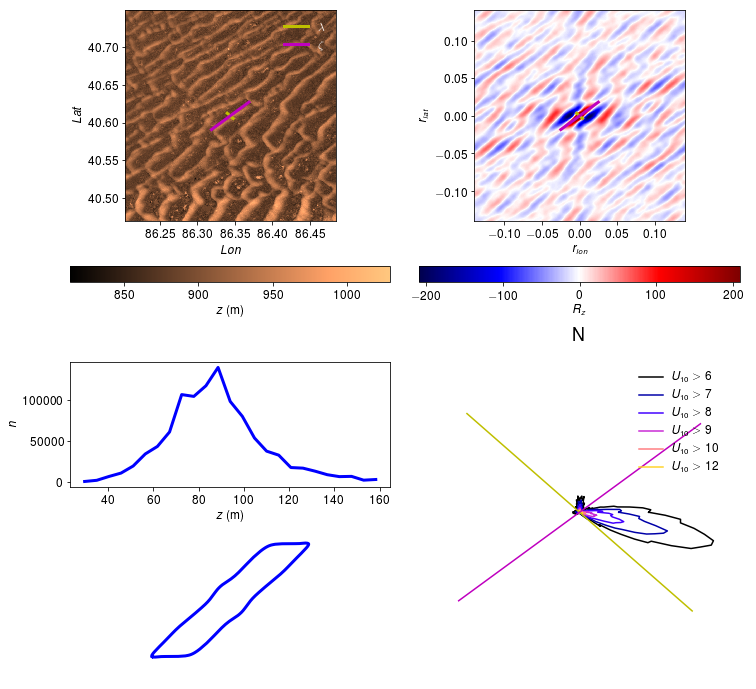

In [346]:
# makes a figure summary of the aster results for a specific era5 tile (loaded above)

mid_tile = int(np.shape(LON_tile)[0]/2)

fs = 12
LW = 3
LW2= 2

v1 = np.min(z_rft_s)
c2=cm.gnuplot2(np.linspace(0,1,resU+1))
c1=['b','r']

fig = plt.gcf()

# this subplot shows the aster DEM of the era5 tile, and also the long and short axes of the forms
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)

sc1 = ax2.pcolormesh(LON_tile,LAT_tile,z_tile, cmap='copper')
sc2 = ax2.plot(LON_tile[mid_tile,mid_tile]+[-I_lon/2,I_lon/2],LAT_tile[mid_tile,mid_tile]+[-I_lat/2,I_lat/2],lw=LW,c='y',label='$\\lambda$')
sc2 = ax2.plot(LON_tile[mid_tile,mid_tile]+[-J_lon/2,J_lon/2],LAT_tile[mid_tile,mid_tile]+[-J_lat/2,J_lat/2],lw=LW,c='m',label='$\\zeta$')

ax2.set_xlabel('$Lon$', fontsize=fs)
ax2.set_ylabel('$Lat$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

l = ax2.legend(loc=0,frameon=False,fontsize=fs)
for text in l.get_texts():
    text.set_color('w')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# keeps lon and lat scaled equally
ax2.set_aspect('equal', 'box')

plt.xlim([np.min(LON_tile),np.max(LON_tile)])
plt.ylim([np.min(LAT_tile),np.max(LAT_tile)])

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$z$ (m)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

# this subplot shows the autocorrelation map of the aster DEM of the era5 tile,
# and also the long and short axes of the forms
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)

sc1 = ax2.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1)
sc2 = ax2.plot([-I_lon/2,I_lon/2],[-I_lat/2,I_lat/2],lw=LW,c='y')
sc2 = ax2.plot([-J_lon/2,J_lon/2],[-J_lat/2,J_lat/2],lw=LW,c='m')

ax2.set_xlabel('$r_{lon}$', fontsize=fs)
ax2.set_ylabel('$r_{lat}$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# keeps lon and lat scaled equally
ax2.set_aspect('equal', 'box')

plt.xlim([np.min(LON_rft_s),np.max(LON_rft_s)])
plt.ylim([np.min(LAT_rft_s),np.max(LAT_rft_s)])

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
# the units of the autocorrelation are technically meters again but
# 2 long modes are removed so the values are unphysical
cbar2.set_label('$R_{z}$',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

# this subplot shows the histogram of the heights of the DEM on a window with a lengthscale
# of the short axis of the dune form
# the mode of this distribution is how the dune height is defined
ax2 = plt.subplot2grid((4, 4), (2, 0), rowspan=1, colspan=2)

for i in np.arange(0,np.shape(Z_meter)[0]):
    sc2 = ax2.plot(Z_bin_edges[i][:-1]+np.diff(Z_bin_edges[i])/2,Z_hist[i],c=c1[i],zorder=0,lw=LW)
    
ax2.set_xlabel('$z$ (m)', fontsize=fs)
ax2.set_ylabel('$n$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# this shows the shape of the dune form
# if there are 2 forms in the tile, they are shown to scale relative to each other
ax2 = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=2)

for i in np.arange(0,np.shape(Polygons)[0]):
    x,y = Polygons[i].exterior.xy

    sc1 = ax2.plot(x,y, color=c1[i], lw=LW)

# make sure the shapes aren't squeezed in lon or lat
ax2.set_aspect('equal', 'box')

plt.axis('off')

# show the era5 10m wind rose for the tile
# only winds over 6 m/s are shown because this is a crude approximation of winds
# doing geomorphic work
# also the directions of long and short axes are given, 
# but the length of these are all the same, not scaled by dune form size
ax2 = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2, projection='polar')

for i in range(0,np.shape(ucrbins)[0]):
    sc = ax2.plot(mA,ha2[i],color=c2[i],label='$U_{10}> %d$'%ucrbins[i])

sc = ax2.plot([AI,AI],[0,1.1*np.max(ha2)],c='y')
sc = ax2.plot([AJ,AJ],[0,1.1*np.max(ha2)],c='m')
sc = ax2.plot([AI-np.pi,AI-np.pi],[0,1.1*np.max(ha2)],c='y')
sc = ax2.plot([AJ-np.pi,AJ-np.pi],[0,1.1*np.max(ha2)],c='m')

plt.ylim([0,1.1*np.max(ha2)])
plt.axis('off')
ax2.set_title('N', loc='center', fontsize=1.5*fs)

ax2.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(12, 12, forward=True)

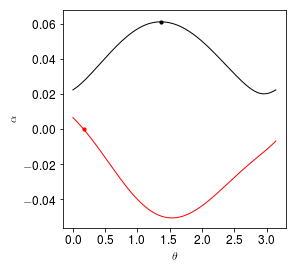

In [348]:
# for the era5 tile above, just illustrate how the dune orientation theory works
bedmode,finmode = duneangles(flux(U,gdia),A)
Tbedmax = np.max(bedmode)
Tbed = T[np.argmax(bedmode)]
Tfinnul = finmode[np.argmin((np.abs(finmode-0)))]
Tfin = T[np.argmin((np.abs(finmode-0)))]

fs = 12
S = 10
LW = 1

fig = plt.gcf()

ax2 = plt.subplot(111)

sc1 = ax2.plot(T,bedmode,'k',lw=LW)
sc1 = ax2.plot(T,finmode,'r',lw=LW)

sc1 = ax2.scatter(Tbed,Tbedmax,c='k',s=S)
sc1 = ax2.scatter(Tfin,Tfinnul,c='r',s=S)

ax2.set_xlabel('$\\theta$', fontsize=fs)
ax2.set_ylabel('$\\alpha$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(4, 4, forward=True)

In [ ]:
# this cell makes the summary figure of the aster results for each era5 tile that has been analysed
# it will make ~2000 pngs in the destination file
# see 2 cells above for what's in each figure

os.chdir("/media/synology2/WANDS/ERA5/dune_tiles1/")
for file in glob.glob("*.pkl"):
    with open(file, 'rb') as f:
         gridcells_era,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)
            
    mid_tile = int(np.shape(LON_tile)[0]/2)

    fs = 12
    LW = 3
    LW2= 2

    v1 = np.min(z_rft_s)
    c2=cm.gnuplot2(np.linspace(0,1,resU+1))
    c1=['b','r']

    fig = plt.gcf()

    ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)

    sc1 = ax2.pcolormesh(LON_tile,LAT_tile,z_tile, cmap='copper')
    sc2 = ax2.plot(LON_tile[mid_tile,mid_tile]+[-I_lon/2,I_lon/2],LAT_tile[mid_tile,mid_tile]+[-I_lat/2,I_lat/2],lw=LW,c='y',label='$\\lambda$')
    sc2 = ax2.plot(LON_tile[mid_tile,mid_tile]+[-J_lon/2,J_lon/2],LAT_tile[mid_tile,mid_tile]+[-J_lat/2,J_lat/2],lw=LW,c='m',label='$\\zeta$')

    ax2.set_xlabel('$Lon$', fontsize=fs)
    ax2.set_ylabel('$Lat$', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    l = ax2.legend(loc=0,frameon=False,fontsize=fs)
    for text in l.get_texts():
        text.set_color('w')

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2.set_aspect('equal', 'box')

    plt.xlim([np.min(LON_tile),np.max(LON_tile)])
    plt.ylim([np.min(LAT_tile),np.max(LAT_tile)])

    cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('$z$ (m)',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)

    sc1 = ax2.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1)
    sc2 = ax2.plot([-I_lon/2,I_lon/2],[-I_lat/2,I_lat/2],lw=LW,c='y')
    sc2 = ax2.plot([-J_lon/2,J_lon/2],[-J_lat/2,J_lat/2],lw=LW,c='m')

    ax2.set_xlabel('$r_{lon}$', fontsize=fs)
    ax2.set_ylabel('$r_{lat}$', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2.set_aspect('equal', 'box')

    plt.xlim([np.min(LON_rft_s),np.max(LON_rft_s)])
    plt.ylim([np.min(LAT_rft_s),np.max(LAT_rft_s)])

    cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('$R_{z}$',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    ax2 = plt.subplot2grid((4, 4), (2, 0), rowspan=1, colspan=2)

    for i in np.arange(0,np.shape(Z_meter)[0]):
        sc2 = ax2.plot(Z_bin_edges[i][:-1]+np.diff(Z_bin_edges[i])/2,Z_hist[i],c=c1[i],zorder=0,lw=LW)

    ax2.set_xlabel('$z$ (m)', fontsize=fs)
    ax2.set_ylabel('$n$', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2 = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=2)

    for i in np.arange(0,np.shape(Polygons)[0]):
        x,y = Polygons[i].exterior.xy

        sc1 = ax2.plot(x,y, color=c1[i], lw=LW)

    ax2.set_aspect('equal', 'box')

    plt.axis('off')

    ax2 = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2, projection='polar')

    for i in range(0,np.shape(ucrbins)[0]):
        sc = ax2.plot(mA,ha2[i],color=c2[i],label='$U_{10}> %d$'%ucrbins[i])

    sc = ax2.plot([AI,AI],[0,1.1*np.max(ha2)],c='y')
    sc = ax2.plot([AJ,AJ],[0,1.1*np.max(ha2)],c='m')
    sc = ax2.plot([AI-np.pi,AI-np.pi],[0,1.1*np.max(ha2)],c='y')
    sc = ax2.plot([AJ-np.pi,AJ-np.pi],[0,1.1*np.max(ha2)],c='m')

    plt.ylim([0,1.1*np.max(ha2)])
    plt.axis('off')
    ax2.set_title('N', loc='center', fontsize=1.5*fs)

    ax2.legend(loc=0,frameon=False,fontsize=fs)

    fig.subplots_adjust(hspace=0.4)

    fig.set_size_inches(12, 12, forward=True)
    plt.savefig('/media/synology2/WANDS/ERA5/dune_tile_figures1/era5_aster%d.png'%int(file[5:-4]), bbox_inches='tight',dpi=300)
    plt.clf()

In [ ]:
# load up all the grain size distributions from a literature review
# these are scraped from written tables or figures (https://apps.automeris.io/wpd/) in papers
# that discuss the dune fields in the era5-aster subset of all dune fields
# DOIs of the papers, and names of all the dune fields in this notebook, can be found here:
# https://docs.google.com/spreadsheets/d/1Hnu556nNkLSABAK73NhOe2SjOIMxw2FO-ToRgPUKrXk/edit?usp=sharing

distdf   = []
distname = []
distsize = []
distperc = []
distmed  = []

# used to find the median of the distributions
medline = LineString([(50,1e-7),(50,1e-1)])

# loop through all the distribution .csvs in the folder
os.chdir("/media/synology2/WANDS/ERA5/dunefield-grains/")
for file in glob.glob("*.csv"):
    tempdata = pd.read_csv(file,delimiter=',',header=0)

    # loop through all the distributions in a given .csv
    for i in np.arange(0,int(np.shape(tempdata)[1]/2)):
        
        # each .csv is named like 'dfXX-C.csv' where XX is the dune field number 
        # and C is a counter of csvs for that XX 
        distdf.append(int(file.split('-')[0][2:]))
#         distdf.append(file)

        # store the name of the distribution, they have the structure NNNYY-ZZ-GSU-DT where
        # NN is the surname of paper's first author, YY is the year of the paper
        # ZZ is the identifier of the distribution used in the paper
        # GSU is the grain size units, millimeters (mm) or phi-scale (phi)
        # DT is the distribution type, cumilative dist. func. (cdf) probability d.f. (pdf) or reverse cdf (rcdf)
        distname.append(tempdata.iloc[:,2*i].name)
        
        # store the percentiles of each point in the distribution
        tempperc = tempdata.iloc[1:,2*i+1].astype('float')
        tempperc = np.delete(np.asarray(tempperc),np.argwhere(np.isnan(tempperc)))
        distperc.append(tempperc)
        
        # store the grain size of each point in the distribution
        # if/else to deal with a scraping error where i accidentally used um instead of mm for a distribution
        if file=='df2-0.csv':
            tempsize = tempdata.iloc[1:,2*i].astype('float')*1e-3
        else:
            tempsize = tempdata.iloc[1:,2*i].astype('float')

        tempsize = np.delete(np.asarray(tempsize),np.argwhere(np.isnan(tempsize)))
        distsize.append(tempsize)
    
# loop through distributions to standardize them all in mm-cdf form
for i in np.arange(0,np.shape(distname)[0]):
    
    # spurious negative percentiles brought to zero
    # this is bc of the figure scraping method
    distperc[i][distperc[i]<0] = 0
        
    # change pdf data to cdf
    if distname[i].split('-')[3]=='pdf':
        distperc[i] = np.cumsum(distperc[i])
        distperc[i] = 100*distperc[i]/distperc[i][-1]
        
    # change the rcdf data to cdf
    if distname[i].split('-')[3]=='rcdf':
        distperc[i] = 100-distperc[i]
        
    # change the phi data to mm
    if distname[i].split('-')[2]=='phi':
        distsize[i] = 2**-distsize[i]
        
    # change the mm data to m
    distsize[i] = distsize[i]*1e-3
    
    # if the distribution is more than one point, make sure the data is cdf
    # this is needed bc increasing phi is decreasing mm...
    # then find the median by seeing where the cdf crosses 50th percentile
    if np.shape(distperc[i])[0]>1:
        if distperc[i][np.argmin(distsize[i])]>distperc[i][np.argmax(distsize[i])]:
            distperc[i] = 100-distperc[i]
    
        dist = LineString(np.vstack((distperc[i],distsize[i])).T)
        distmed.append(dist.intersection(medline).coords.xy[1][0])
    else:
        distmed.append(float(distsize[i]))
    
distmed = np.asarray(distmed)

# sort the medians into a list of arrays per dune field
distmedsbydf = []
for i in np.arange(0,np.shape(duneareas)[0]):
    distmedsbydf.append(distmed[np.argwhere(distdf==i)])

In [349]:
# here i loop through the pickles of each tile and store values in arrays of common variables
# this cell takes a long time to run because a lot of data is accessed and the flux/angle functions compute
# for this reason i store the results in a new pickle, which can be loaded in the cell below

# initialize lists
I_M  = []
J_M  = []
Z_M  = []
Is_M = []
Js_M = []
Zs_M = []
Il_M = []
Jl_M = []
Zl_M = []

AIa = []
AJa = []
AIs = []
AJs = []
AIl = []
AJl = []

DRa = []
DRas = []
DRal = []

tileno   = []

Q = []
BEDA = []
FINA = []

# loop through era5 tiles
os.chdir("/media/synology2/WANDS/ERA5/dune_tiles1/")
for file in glob.glob("*.pkl"):
    with open(file, 'rb') as f:
         gridcells_era,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)
           
    # find the flux with 300 micron grain diamater for all
    q = flux(U,gdia)
    Q.append(q)
    
    # find dune angles
    bedmode,finmode = duneangles(q,A)
    Tbedmax = np.max(bedmode)
    Tbed = T[np.argmax(bedmode)]
    Tfinnul = finmode[np.argmin((np.abs(finmode-0)))]
    Tfin = T[np.argmin((np.abs(finmode-0)))]

    BEDA.append(Tbed)
    FINA.append(Tfin)
    
    # store dune geometries
    # if a tile only has one form, it is counted in both 
    # the large (i.e. Il_M) and small (i.e. Is_M) geometry arrays
    # if a tile has two forms, only the largest is in the large array, small in small
    # this means the length of the small and large arrays is the same as the number of tiles
    # the full geometry arrays (i.e. I_M) are longer than the number of tiles (by the number of 2-form tiles)
    
    if np.shape(I_meter)[0]==2:
        smallerind = np.argmin(I_meter)
        Is_M.append(I_meter[smallerind])
        Js_M.append(J_meter[smallerind])
        Zs_M.append(Z_meter[smallerind])
        
        AIs.append(AI[smallerind])
        AJs.append(AJ[smallerind])
        
        DRas.append(DR[smallerind])

        largerind = np.argmax(I_meter)
        Il_M.append(I_meter[largerind])
        Jl_M.append(J_meter[largerind])
        Zl_M.append(Z_meter[largerind])
        
        AIl.append(AI[largerind])
        AJl.append(AJ[largerind])
        
        DRal.append(DR[largerind])
        
    else:
        Is_M.append(I_meter[0])
        Js_M.append(J_meter[0])
        Zs_M.append(Z_meter[0])

        AIs.append(AI[0])
        AJs.append(AJ[0])        

        DRas.append(DR[0])

        Il_M.append(I_meter[0])
        Jl_M.append(J_meter[0])
        Zl_M.append(Z_meter[0])
        
        AIl.append(AI[0])
        AJl.append(AJ[0])
        
        DRal.append(DR[0])
        
    I_M.append(I_meter)
    J_M.append(J_meter)
    Z_M.append(Z_meter)
    
    AIa.append(AI)
    AJa.append(AJ)
    
    # this is the ratio of the correlated form area to the dune area
    DRa.append(DR)
    
    # store the tile number
    tileno.append(int(file[5:-4]))
    
I_M  = np.concatenate(np.asarray(I_M))
J_M  = np.concatenate(np.asarray(J_M))
Z_M  = np.concatenate(np.asarray(Z_M))

AIa = np.concatenate(np.asarray(AIa))
AJa = np.concatenate(np.asarray(AJa))

DRa  = np.concatenate(np.asarray(DRa))


Is_M  = np.asarray(Is_M)
Js_M  = np.asarray(Js_M)
Zs_M  = np.asarray(Zs_M)

AIs = np.asarray(AIs)
AJs = np.asarray(AJs)

DRas  = np.asarray(DRas)


Il_M  = np.asarray(Il_M)
Jl_M  = np.asarray(Jl_M)
Zl_M  = np.asarray(Zl_M)

AIl = np.asarray(AIl)
AJl = np.asarray(AJl)

DRal  = np.asarray(DRal)


tileno   = np.asarray(tileno)

Q = np.asarray(Q)
Qtot = np.sum(Q,axis=1)
BEDA = np.asarray(BEDA)
FINA = np.asarray(FINA)

In [396]:
# store the variable arrays in the cell above
with open('/media/synology2/WANDS/ERA5/combined.pkl', 'wb') as f:
    pickle.dump((I_M,J_M,Z_M,
                 Is_M,Js_M,Zs_M,Il_M,Jl_M,Zl_M,
                 AIa,AJa,AIs,AJs,AIl,AJl,
                 DRa,DRas,DRal,
                 tileno,
                 Q,BEDA,FINA)
                , f)

In [350]:
# for the flux data (with constant 300 micron grain size) find the slope and scale factor of the powerlaw
# that fits the distribution

PQ = np.empty((np.shape(Q)[0],2))
for i in np.arange(0,np.shape(Q)[0]):
    temp = Q[i,:]
    cnts,bins = np.histogram(temp[temp!=0],bins=100)
    binmids = bins[:-1]+np.diff(bins)/2
    logcnts = np.log(cnts)
    PQ[i,:] = np.polyfit(binmids[~np.isinf(logcnts)],logcnts[~np.isinf(logcnts)],deg=1)

In [384]:
#find volume of the small and large dune forms
Vl_M = Il_M*Jl_M*Zl_M
Vs_M = Is_M*Js_M*Zs_M

# to compare dune areas to dune geometries, make these comparison arrays
# this gives an array the same size as the number of tiles
# where each element is the area of the dune field the tile is in
# the tileindices array gives the dune field number the tile is in
# this is because the order tiles is read, and therefore the variable array element order, is a mess
tileindices = np.empty([np.shape(tileno)[0],2])
DF_AREA = np.empty(np.shape(tileno)[0])
for i in np.arange(0,np.shape(tileno)[0]):
    for j in np.arange(0,np.shape(ondunes)[0]):
        if np.shape(np.argwhere(ondunes[j]==tileno[i]))[0]!=0:
            tileindices[i,:] = [j,np.argwhere(ondunes[j]==tileno[i])[0][0]]
            DF_AREA[i] = duneareas[j]

tileindices = tileindices.astype(int)
        
# now get dune field specific diagnostic varaible quantities
# i.e. the variance in large dune widths for each dune field

zl_mean = np.empty(np.shape(duneareas)[0])
zl_vari = np.empty(np.shape(duneareas)[0])
zl_medi = np.empty(np.shape(duneareas)[0])
il_mean = np.empty(np.shape(duneareas)[0])
il_vari = np.empty(np.shape(duneareas)[0])
il_medi = np.empty(np.shape(duneareas)[0])
jl_mean = np.empty(np.shape(duneareas)[0])
jl_vari = np.empty(np.shape(duneareas)[0])
jl_medi = np.empty(np.shape(duneareas)[0])
drl_mean = np.empty(np.shape(duneareas)[0])
drl_vari = np.empty(np.shape(duneareas)[0])
drl_medi = np.empty(np.shape(duneareas)[0])

zs_mean = np.empty(np.shape(duneareas)[0])
zs_vari = np.empty(np.shape(duneareas)[0])
zs_medi = np.empty(np.shape(duneareas)[0])
is_mean = np.empty(np.shape(duneareas)[0])
is_vari = np.empty(np.shape(duneareas)[0])
is_medi = np.empty(np.shape(duneareas)[0])
js_mean = np.empty(np.shape(duneareas)[0])
js_vari = np.empty(np.shape(duneareas)[0])
js_medi = np.empty(np.shape(duneareas)[0])
drs_mean = np.empty(np.shape(duneareas)[0])
drs_vari = np.empty(np.shape(duneareas)[0])
drs_medi = np.empty(np.shape(duneareas)[0])

vl_mean = np.empty(np.shape(duneareas)[0])
vl_vari = np.empty(np.shape(duneareas)[0])
vl_medi = np.empty(np.shape(duneareas)[0])
vs_mean = np.empty(np.shape(duneareas)[0])
vs_vari = np.empty(np.shape(duneareas)[0])
vs_medi = np.empty(np.shape(duneareas)[0])

q_mean = np.empty(np.shape(duneareas)[0])
q_vari = np.empty(np.shape(duneareas)[0])
q_medi = np.empty(np.shape(duneareas)[0])

d50_mean = np.empty(np.shape(duneareas)[0])
d50_vari = np.empty(np.shape(duneareas)[0])

for i in np.arange(0,np.shape(duneareas)[0]):
    dunetiles = np.argwhere(tileindices[:,0]==i)
   
    zl_mean[i] = np.mean(Zl_M[dunetiles])
    zl_vari[i] = np.var(Zl_M[dunetiles])
    zl_medi[i] = np.median(Zl_M[dunetiles])
    il_mean[i] = np.mean(Il_M[dunetiles])
    il_vari[i] = np.var(Il_M[dunetiles])
    il_medi[i] = np.median(Il_M[dunetiles])
    jl_mean[i] = np.mean(Jl_M[dunetiles])
    jl_vari[i] = np.var(Jl_M[dunetiles])
    jl_medi[i] = np.median(Jl_M[dunetiles])
    drl_mean[i] = np.mean(DRal[dunetiles])
    drl_vari[i] = np.var(DRal[dunetiles])   
    drl_medi[i] = np.median(DRal[dunetiles])
    zs_mean[i] = np.mean(Zs_M[dunetiles])
    zs_vari[i] = np.var(Zs_M[dunetiles])
    zs_medi[i] = np.median(Zs_M[dunetiles])
    is_mean[i] = np.mean(Is_M[dunetiles])
    is_vari[i] = np.var(Is_M[dunetiles])
    is_medi[i] = np.median(Is_M[dunetiles])
    js_mean[i] = np.mean(Js_M[dunetiles])
    js_vari[i] = np.var(Js_M[dunetiles])
    js_medi[i] = np.median(Js_M[dunetiles])
    drs_mean[i] = np.mean(DRas[dunetiles])
    drs_vari[i] = np.var(DRas[dunetiles])  
    drs_medi[i] = np.median(DRas[dunetiles])

    vl_mean[i] = np.mean(Vl_M[dunetiles])
    vl_vari[i] = np.var(Vl_M[dunetiles])
    vl_medi[i] = np.median(Vl_M[dunetiles])
    vs_mean[i] = np.mean(Vl_M[dunetiles])
    vs_vari[i] = np.var(Vl_M[dunetiles])
    vs_medi[i] = np.median(Vl_M[dunetiles])
    
    q_mean[i] = np.mean(Qtot[dunetiles])
    q_vari[i] = np.var(Qtot[dunetiles])  
    q_medi[i] = np.median(Qtot[dunetiles])
    
    graindists = np.argwhere(np.asarray(distdf)==i)
    
    d50_mean[i] = np.mean(distmed[graindists])
    d50_vari[i] = np.var(distmed[graindists])     
    
# gets the order of indices that would sort these arrays to go from smallest to largest dune field
# important for plotting lines, not dots
bydunearea = np.argsort(duneareas)

# this is useful for data scaled by dune field area
tilearea = 32**2

# this is the total flux of the dune field
q_ascaled_mean = q_mean*duneareas/tilearea
q_ascaled_vari = q_vari*duneareas/tilearea

# this is the total volume of sand in each dune field
# is is divided by 4 because it is halved for each horizontal dimension
# i.e. approx. half the wavelength axis is dune, and half the length axis is dune
vl_ascaled_mean = zl_mean*duneareas/4
vl_ascaled_vari = zl_vari*duneareas/4
vs_ascaled_mean = zs_mean*duneareas/4
vs_ascaled_vari = zs_vari*duneareas/4

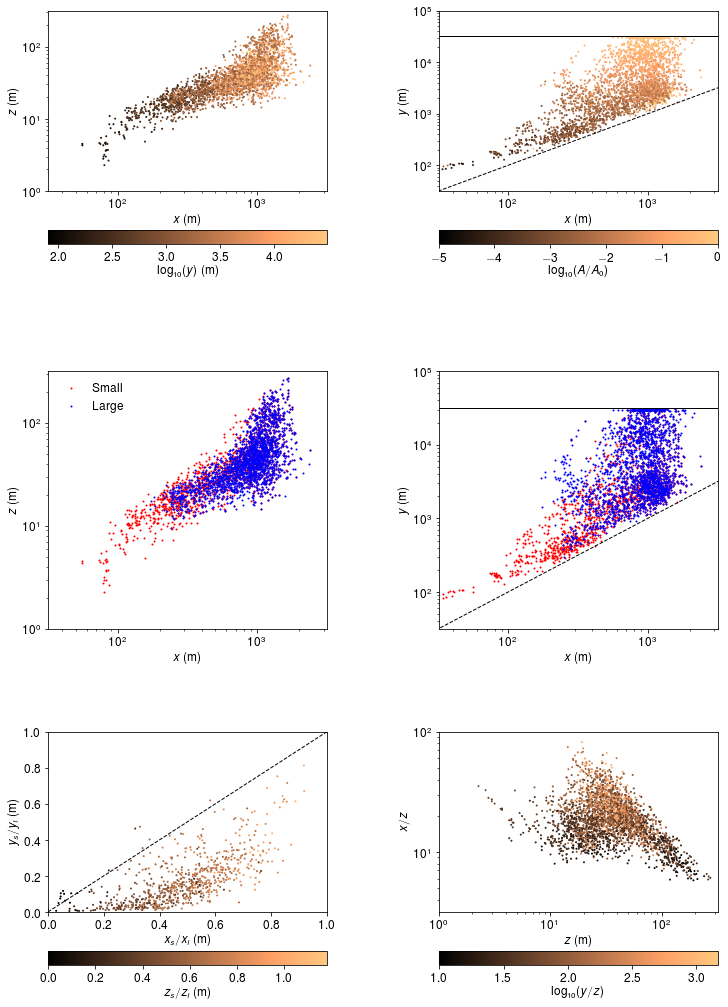

In [302]:
# plot dune geometry results

fs = 12
LW = 1
S = 1

c2=cm.gnuplot2(np.linspace(0,1,resU+1))

fig = plt.gcf()

# wavelength vs height
ax2 = plt.subplot(321)

sc1 = ax2.scatter(I_M, Z_M, c=np.log10(J_M),cmap='copper',s=S)

ax2.set_xlabel('$x$ (m)', fontsize=fs)
ax2.set_ylabel('$z$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**1.5,10**3.5)
plt.ylim(10**0,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$\\log_{10}(y)$ (m)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

# wavelength vs width
# width measurment limit (tile lengthscale) is marked
# so is 1:1 line, i.e. star dunes / barchans are closer to this line
ax2 = plt.subplot(322)

sc1 = ax2.scatter(I_M, J_M, c=np.log10(DRa),cmap='copper',s=S,vmin=-5,vmax=0)

sc2 = ax2.plot([1,10**8],[1,10**8],'--k',lw=LW)
sc2 = ax2.plot([1,10**8],[3.2*10**4,3.2*10**4],'k',lw=LW)

ax2.set_xlabel('$x$ (m)', fontsize=fs)
ax2.set_ylabel('$y$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**1.5,10**3.5)
plt.ylim(10**1.5,10**5)

ax2.set_xscale('log')
ax2.set_yscale('log')

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$\\log_{10}(A/A_{0})$',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

# same as plot above but
# data colored by small and large forms for same tile
ax2 = plt.subplot(323)

sc1 = ax2.scatter(Is_M, Zs_M, c='r',s=S,label='Small')
sc1 = ax2.scatter(Il_M, Zl_M, c='b',s=S,label='Large')

ax2.set_xlabel('$x$ (m)', fontsize=fs)
ax2.set_ylabel('$z$ (m)', fontsize=fs)    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**1.5,10**3.5)
plt.ylim(10**0,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

l = ax2.legend(loc=0,frameon=False,fontsize=fs)

# same as plot above but
# data colored by small and large forms for same tile
ax2 = plt.subplot(324)

sc1 = ax2.scatter(Is_M, Js_M, c='r',s=S)
sc1 = ax2.scatter(Il_M, Jl_M, c='b',s=S)

sc2 = ax2.plot([1,10**8],[1,10**8],'--k',lw=LW)
sc2 = ax2.plot([1,10**8],[3.2*10**4,3.2*10**4],'k',lw=LW)

ax2.set_xlabel('$x$ (m)', fontsize=fs)
ax2.set_ylabel('$y$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**1.5,10**3.5)
plt.ylim(10**1.5,10**5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# ratio of small to large form wavelengths and widths
# 1:1 line is here to show if forms have 'twisted' whilst being superimposed
ax2 = plt.subplot(325)

sc1 = ax2.scatter(Is_M/Il_M, Js_M/Jl_M, c=Zs_M/Zl_M, cmap='copper',s=S)

sc2 = ax2.plot([0,1],[0,1],'--k',lw=LW)

ax2.set_xlabel('$x_s/x_l$ (m)', fontsize=fs)
ax2.set_ylabel('$y_s/y_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(0,1)
plt.ylim(0,1)

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$z_s/z_l$ (m)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

# aspect ratio plot, height vs ratio of wavelength to height
ax2 = plt.subplot(326)

sc1 = ax2.scatter(Z_M, I_M/Z_M, c=np.log10(J_M/Z_M), cmap='copper',s=S)

ax2.set_xlabel('$z$ (m)', fontsize=fs)
ax2.set_ylabel('$x/z$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0,10**2.5)
plt.ylim(10**0.5,10**2)

ax2.set_xscale('log')
ax2.set_yscale('log')

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$\\log_{10}(y/z)$',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(12, 18, forward=True)
fig.savefig('/home/andrew/Desktop/dunegeoms.png',dpi=300)

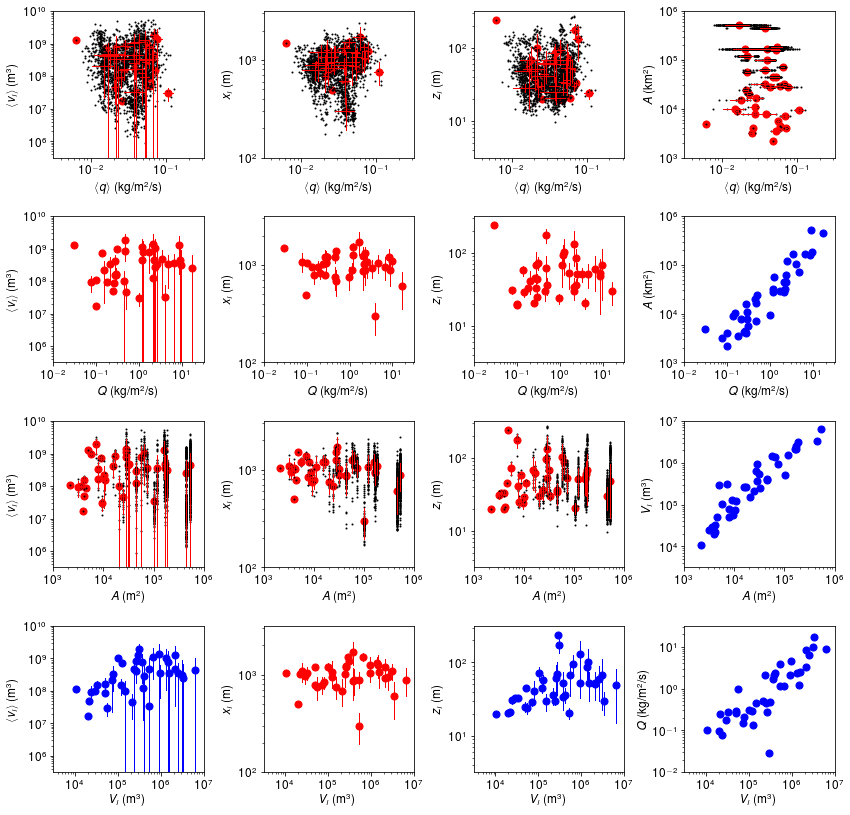

In [304]:
# results figure on the relationship between era5 or area data and aster data
# subplots with blue colors have some form of autocorrelation, sometimes strong, sometimes weak
# these suplots all use the flux using the representative grainsize of 300 microns

fs = 12
LW = 1
S = 1

S1 = 50

fig = plt.gcf()

# flux from the local tile vs its large form volume
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,1)

sc2 = ax2.scatter(q_mean,vl_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [vl_mean-vl_vari**0.5,vl_mean+vl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [vl_mean,vl_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Vl_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux from the local tile vs its large form wavelength
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,2)

sc2 = ax2.scatter(q_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [il_mean,il_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Il_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux from the local tile vs its large form height
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,3)

sc2 = ax2.scatter(q_mean,zl_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [zl_mean,zl_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Zl_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux from the local tile vs area of dune field it's in
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,4)

sc2 = ax2.scatter(q_mean,duneareas,c='r',s=S1)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [duneareas,duneareas],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, DF_AREA, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$A$ (km$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**3,10**6)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux of the entire dune field vs its average large form volume
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,5)

sc2 = ax2.scatter(q_ascaled_mean,vl_mean,c='r',s=S1)
sc3 = ax2.plot([q_ascaled_mean,q_ascaled_mean], 
               [vl_mean-vl_vari**0.5,vl_mean+vl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_ascaled_mean+q_ascaled_vari**0.5,q_ascaled_mean-q_ascaled_vari**0.5], 
               [vl_mean,vl_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux of the entire dune field vs its average large form wavelength
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,6)

sc2 = ax2.scatter(q_ascaled_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([q_ascaled_mean,q_ascaled_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_ascaled_mean+q_ascaled_vari**0.5,q_ascaled_mean-q_ascaled_vari**0.5], 
               [il_mean,il_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux of the entire dune field vs its average large form height
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,7)

sc2 = ax2.scatter(q_ascaled_mean,zl_mean,c='r',s=S1)
sc3 = ax2.plot([q_ascaled_mean,q_ascaled_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_ascaled_mean+q_vari**0.5,q_ascaled_mean-q_vari**0.5], 
               [zl_mean,zl_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# flux of the entire dune field vs its area
# also mean with standard deviation error bars for each dune field
# this is autocorrelated bc the x axis is the average tile flux scaled by the dune field area over tile area
ax2 = plt.subplot(4,4,8)

sc2 = ax2.scatter(q_ascaled_mean,duneareas,c='b',s=S1)
sc4 = ax2.plot([q_ascaled_mean+q_ascaled_vari**0.5,q_ascaled_mean-q_ascaled_vari**0.5], 
               [duneareas,duneareas],
               'b',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$A$ (km$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**3,10**6)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field area vs its dune volumes
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,9)

sc2 = ax2.scatter(duneareas,vl_mean,c='r',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [vl_mean-vl_vari**0.5,vl_mean+vl_vari**0.5],
               'r',lw=LW)

sc1 = ax2.scatter(DF_AREA, Vl_M, c='k',s=S)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field area vs its dune wavelengths
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,10)

sc2 = ax2.scatter(duneareas,il_mean,c='r',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)

sc1 = ax2.scatter(DF_AREA, Il_M, c='k',s=S)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field area vs its dune heights
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,11)

sc2 = ax2.scatter(duneareas,zl_mean,c='r',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)

sc1 = ax2.scatter(DF_AREA, Zl_M, c='k',s=S)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field area vs its volume
# also mean with standard deviation error bars for each dune field
# this is autocorrelated bc the volume is quarter the av dune height scaled by the dune field area
ax2 = plt.subplot(4,4,12)

sc2 = ax2.scatter(duneareas,vl_ascaled_mean,c='b',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [vl_ascaled_mean-vl_ascaled_vari**0.5,vl_ascaled_mean+vl_ascaled_vari**0.5],
               'b',lw=LW)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$V_l$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**3.5,10**7)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field volume vs average dune volume
# also mean with standard deviation error bars for each dune field
# this is autocorrelated bc the dune field volume is quarter the av dune height scaled by the dune field area
# and the dune volume is the wavelength*width*height
ax2 = plt.subplot(4,4,13)

sc2 = ax2.scatter(vl_ascaled_mean,vl_mean,c='b',s=S1)
sc3 = ax2.plot([vl_ascaled_mean,vl_ascaled_mean], 
               [vl_mean-vl_vari**0.5,vl_mean+vl_vari**0.5],
               'b',lw=LW)

ax2.set_xlabel('$V_l$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field volume vs average wavelength
# also mean with standard deviation error bars for each dune field
ax2 = plt.subplot(4,4,14)

sc2 = ax2.scatter(vl_ascaled_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([vl_ascaled_mean,vl_ascaled_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)

ax2.set_xlabel('$V_l$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field volume vs average dune height
# also mean with standard deviation error bars for each dune field
# this is autocorrelated bc the volume is quarter the av dune height scaled by the dune field area
ax2 = plt.subplot(4,4,15)

sc2 = ax2.scatter(vl_ascaled_mean,zl_mean,c='b',s=S1)
sc3 = ax2.plot([vl_ascaled_mean,vl_ascaled_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'b',lw=LW)

ax2.set_xlabel('$V_l$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# dune field volume vs its flux
# also mean with standard deviation error bars for each dune field
# this is autocorrelated bc the volume is quarter the av dune height scaled by the *dune field area*
# and the total flux is the average tile flux scaled by the ratio of *dune field area* to tile area
ax2 = plt.subplot(4,4,16)

sc2 = ax2.scatter(vl_ascaled_mean,q_ascaled_mean,c='b',s=S1)
sc3 = ax2.plot([vl_ascaled_mean,vl_ascaled_mean], 
               [q_ascaled_mean-q_ascaled_vari**0.5,q_ascaled_mean+q_ascaled_vari**0.5],
               'b',lw=LW)
sc4 = ax2.plot([vl_ascaled_mean-vl_ascaled_vari**0.5,vl_ascaled_mean+vl_ascaled_vari**0.5], 
               [q_ascaled_mean,q_ascaled_mean],
               'b',lw=LW)

ax2.set_xlabel('$V_l$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**-2,10**1.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(14, 14, forward=True)
fig.savefig('/home/andrew/Desktop/largecorrelations.png',dpi=300)

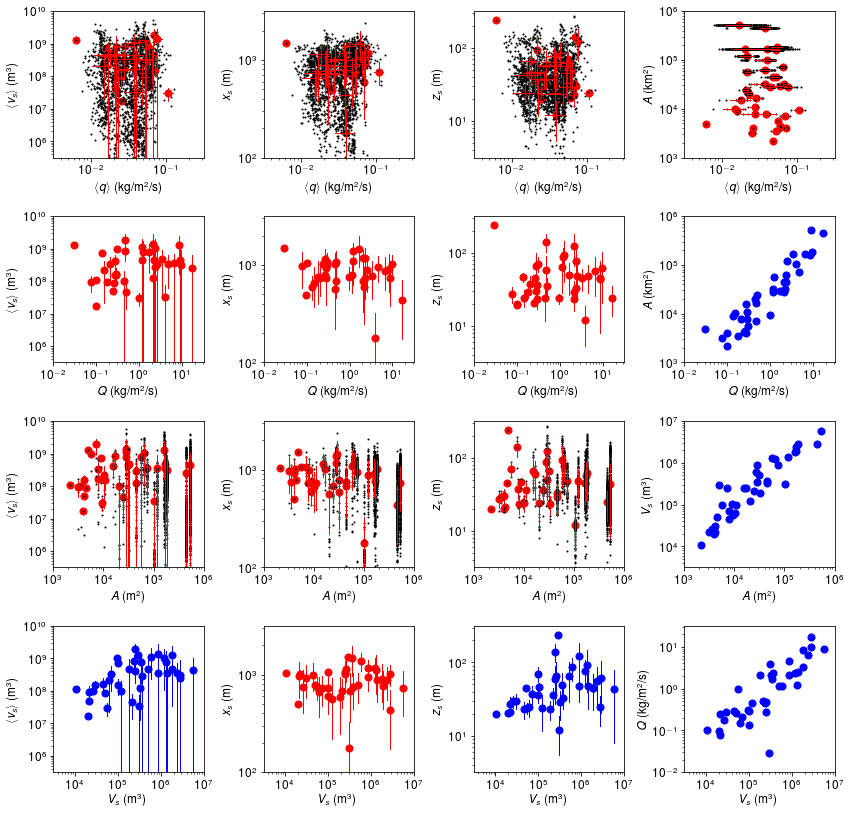

In [305]:
# same as plot above but for the small dune forms

fs = 12
LW = 1
S = 1

S1 = 50

fig = plt.gcf()

ax2 = plt.subplot(4,4,1)

sc2 = ax2.scatter(q_mean,vl_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [vs_mean-vs_vari**0.5,vs_mean+vs_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [vs_mean,vs_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Vs_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$\\langle v_s \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,2)

sc2 = ax2.scatter(q_mean,is_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [is_mean-is_vari**0.5,is_mean+is_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [is_mean,is_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Is_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,3)

sc2 = ax2.scatter(q_mean,zs_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [zs_mean-zs_vari**0.5,zs_mean+zs_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [zs_mean,zs_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Zs_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,4)

sc2 = ax2.scatter(q_mean,duneareas,c='r',s=S1)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [duneareas,duneareas],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, DF_AREA, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$A$ (km$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**3,10**6)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,5)

sc2 = ax2.scatter(q_ascaled_mean,vs_mean,c='r',s=S1)
sc3 = ax2.plot([q_ascaled_mean,q_ascaled_mean], 
               [vs_mean-vs_vari**0.5,vs_mean+vs_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_ascaled_mean+q_ascaled_vari**0.5,q_ascaled_mean-q_ascaled_vari**0.5], 
               [vs_mean,vs_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$\\langle v_s \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,6)

sc2 = ax2.scatter(q_ascaled_mean,is_mean,c='r',s=S1)
sc3 = ax2.plot([q_ascaled_mean,q_ascaled_mean], 
               [is_mean-is_vari**0.5,is_mean+is_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_ascaled_mean+q_ascaled_vari**0.5,q_ascaled_mean-q_ascaled_vari**0.5], 
               [is_mean,is_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,7)

sc2 = ax2.scatter(q_ascaled_mean,zs_mean,c='r',s=S1)
sc3 = ax2.plot([q_ascaled_mean,q_ascaled_mean], 
               [zs_mean-zs_vari**0.5,zs_mean+zs_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_ascaled_mean+q_vari**0.5,q_ascaled_mean-q_vari**0.5], 
               [zs_mean,zs_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,8)

sc2 = ax2.scatter(q_ascaled_mean,duneareas,c='b',s=S1)
sc4 = ax2.plot([q_ascaled_mean+q_ascaled_vari**0.5,q_ascaled_mean-q_ascaled_vari**0.5], 
               [duneareas,duneareas],
               'b',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$A$ (km$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**1.5)
plt.ylim(10**3,10**6)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,9)

sc2 = ax2.scatter(duneareas,vs_mean,c='r',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [vs_mean-vs_vari**0.5,vs_mean+vs_vari**0.5],
               'r',lw=LW)

sc1 = ax2.scatter(DF_AREA, Vs_M, c='k',s=S)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$\\langle v_s \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,10)

sc2 = ax2.scatter(duneareas,is_mean,c='r',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [is_mean-is_vari**0.5,is_mean+is_vari**0.5],
               'r',lw=LW)

sc1 = ax2.scatter(DF_AREA, Is_M, c='k',s=S)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$x_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,11)

sc2 = ax2.scatter(duneareas,zs_mean,c='r',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [zs_mean-zs_vari**0.5,zs_mean+zs_vari**0.5],
               'r',lw=LW)

sc1 = ax2.scatter(DF_AREA, Zs_M, c='k',s=S)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$z_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,12)

sc2 = ax2.scatter(duneareas,vs_ascaled_mean,c='b',s=S1)
sc3 = ax2.plot([duneareas,duneareas], 
               [vs_ascaled_mean-vs_ascaled_vari**0.5,vs_ascaled_mean+vs_ascaled_vari**0.5],
               'b',lw=LW)

ax2.set_xlabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_ylabel('$V_s$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3,10**6)
plt.ylim(10**3.5,10**7)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,13)

sc2 = ax2.scatter(vs_ascaled_mean,vs_mean,c='b',s=S1)
sc3 = ax2.plot([vs_ascaled_mean,vs_ascaled_mean], 
               [vs_mean-vs_vari**0.5,vs_mean+vs_vari**0.5],
               'b',lw=LW)

ax2.set_xlabel('$V_s$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$\\langle v_s \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,14)

sc2 = ax2.scatter(vs_ascaled_mean,is_mean,c='r',s=S1)
sc3 = ax2.plot([vs_ascaled_mean,vs_ascaled_mean], 
               [is_mean-is_vari**0.5,is_mean+is_vari**0.5],
               'r',lw=LW)

ax2.set_xlabel('$V_s$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$x_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,15)

sc2 = ax2.scatter(vs_ascaled_mean,zs_mean,c='b',s=S1)
sc3 = ax2.plot([vs_ascaled_mean,vs_ascaled_mean], 
               [zs_mean-zs_vari**0.5,zs_mean+zs_vari**0.5],
               'b',lw=LW)

ax2.set_xlabel('$V_s$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$z_s$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(4,4,16)

sc2 = ax2.scatter(vs_ascaled_mean,q_ascaled_mean,c='b',s=S1)
sc3 = ax2.plot([vs_ascaled_mean,vs_ascaled_mean], 
               [q_ascaled_mean-q_ascaled_vari**0.5,q_ascaled_mean+q_ascaled_vari**0.5],
               'b',lw=LW)
sc4 = ax2.plot([vs_ascaled_mean-vs_ascaled_vari**0.5,vs_ascaled_mean+vs_ascaled_vari**0.5], 
               [q_ascaled_mean,q_ascaled_mean],
               'b',lw=LW)

ax2.set_xlabel('$V_s$ (m$^{3}$)', fontsize=fs)
ax2.set_ylabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**3.5,10**7)
plt.ylim(10**-2,10**1.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(14, 14, forward=True)
fig.savefig('/home/andrew/Desktop/smallcorrelations.png',dpi=300)

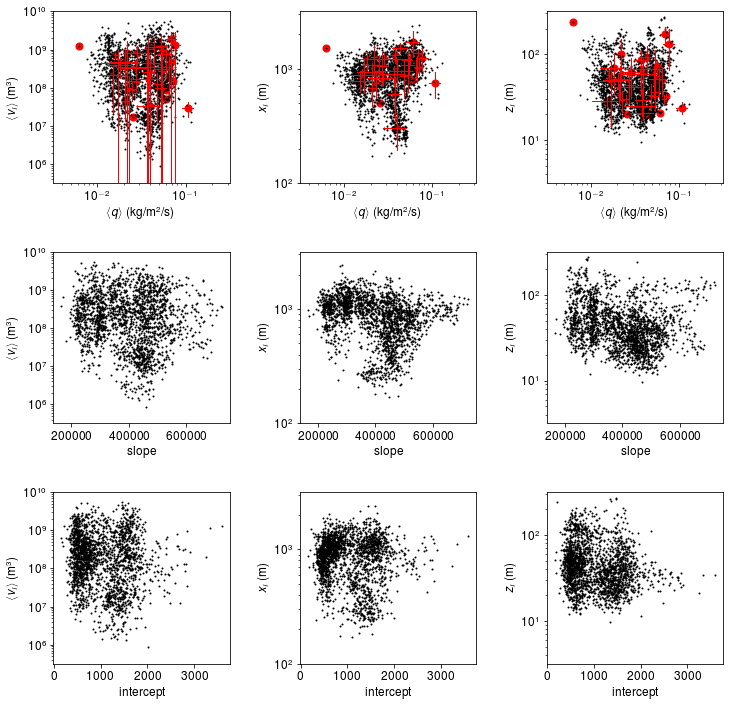

In [306]:
# this plot looks at the same geometry variables as the plot 2 above
# but is against the total, distribution scale factor, and power-law slope of the flux
# this is the flux using the representative grainsize of 300 microns

fs = 12
LW = 1
S = 1

S1 = 50

fig = plt.gcf()

ax2 = plt.subplot(331)

sc2 = ax2.scatter(q_mean,vl_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [vl_mean-vl_vari**0.5,vl_mean+vl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [vl_mean,vl_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Vl_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**5.5,10**10)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(332)

sc2 = ax2.scatter(q_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [il_mean,il_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Il_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(333)

sc2 = ax2.scatter(q_mean,zl_mean,c='r',s=S1)
sc3 = ax2.plot([q_mean,q_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([q_mean+q_vari**0.5,q_mean-q_vari**0.5], 
               [zl_mean,zl_mean],
               'r',lw=LW)

sc1 = ax2.scatter(Qtot, Zl_M, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(334)

sc1 = ax2.scatter(-PQ[:,0], Vl_M, c='k',s=S)

ax2.set_xlabel('slope', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**5.5,10**10)

# ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(335)

sc1 = ax2.scatter(-PQ[:,0], Il_M, c='k',s=S)

ax2.set_xlabel('slope', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**2,10**3.5)

# ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(336)

sc1 = ax2.scatter(-PQ[:,0], Zl_M, c='k',s=S)

ax2.set_xlabel('slope', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**0.5,10**2.5)

# ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(337)

sc1 = ax2.scatter(np.exp(PQ[:,1]), Vl_M, c='k',s=S)

ax2.set_xlabel('intercept', fontsize=fs)
ax2.set_ylabel('$\\langle v_l \\rangle$ (m$^{3}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**5.5,10**10)

# ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(338)

sc1 = ax2.scatter(np.exp(PQ[:,1]), Il_M, c='k',s=S)

ax2.set_xlabel('intercept', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**2,10**3.5)

# ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(339)

sc1 = ax2.scatter(np.exp(PQ[:,1]), Zl_M, c='k',s=S)

ax2.set_xlabel('intercept', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.xlim(10**-2.5,10**-0.5)
plt.ylim(10**0.5,10**2.5)

# ax2.set_xscale('log')
ax2.set_yscale('log')

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(12, 12, forward=True)
fig.savefig('/home/andrew/Desktop/qmetriccorrelations.png',dpi=300)

In [352]:
# compare the courrech du pont 2014 orientation theory to data

# there are eight options to look at the theory to data residual
# the second two lines are to deal with looping angle issues

# short form long axis to bed-mode
bedjs = AJs-BEDA
bedjs[bedjs<-np.pi/2] = bedjs[bedjs<-np.pi/2]+np.pi
bedjs[bedjs>np.pi/2]  = bedjs[bedjs>np.pi/2]-np.pi

# long form long axis to bed-mode
bedjl = AJl-BEDA
bedjl[bedjl<-np.pi/2] = bedjl[bedjl<-np.pi/2]+np.pi
bedjl[bedjl>np.pi/2]  = bedjl[bedjl>np.pi/2]-np.pi

# short form short axis to bed-mode
bedis = AIs-BEDA
bedis[bedis<-np.pi/2] = bedis[bedis<-np.pi/2]+np.pi
bedis[bedis>np.pi/2]  = bedis[bedis>np.pi/2]-np.pi

# large form short axis to bed-mode
bedil = AIl-BEDA
bedil[bedil<-np.pi/2] = bedil[bedil<-np.pi/2]+np.pi
bedil[bedil>np.pi/2]  = bedil[bedil>np.pi/2]-np.pi

# same as 4 above but to finger-mode
finjs = AJs-FINA
finjs[finjs<-np.pi/2] = finjs[finjs<-np.pi/2]+np.pi
finjs[finjs>np.pi/2]  = finjs[finjs>np.pi/2]-np.pi

finjl = AJl-FINA
finjl[finjl<-np.pi/2] = finjl[finjl<-np.pi/2]+np.pi
finjl[finjl>np.pi/2]  = finjl[finjl>np.pi/2]-np.pi

finis = AIs-FINA
finis[finis<-np.pi/2] = finis[finis<-np.pi/2]+np.pi
finis[finis>np.pi/2]  = finis[finis>np.pi/2]-np.pi

finil = AIl-FINA
finil[finil<-np.pi/2] = finil[finil<-np.pi/2]+np.pi
finil[finil>np.pi/2]  = finil[finil>np.pi/2]-np.pi

# find the option of the 8 above with the smallest theory-observation residual
masteranglediff = np.asarray([bedjl,bedjs,bedil,bedis,finjl,finjs,finil,finis])
bestfitarg = np.argmin(np.abs(masteranglediff),axis=0)
bestanglediff = np.empty(np.shape(masteranglediff)[1])
for i in np.arange(0,np.shape(masteranglediff)[1]):
    bestanglediff[i] = masteranglediff[bestfitarg[i],i]

# make histograms of the residuals
binno = 45

bedjshist,thetabinedges = np.histogram(bedjs,range=(-np.pi,np.pi),bins=binno)
bedjlhist,_             = np.histogram(bedjl,range=(-np.pi,np.pi),bins=binno)
bedishist,_             = np.histogram(bedis,range=(-np.pi,np.pi),bins=binno)
bedilhist,_             = np.histogram(bedil,range=(-np.pi,np.pi),bins=binno)
finjshist,_             = np.histogram(finjs,range=(-np.pi,np.pi),bins=binno)
finjlhist,_             = np.histogram(finjl,range=(-np.pi,np.pi),bins=binno)
finishist,_             = np.histogram(finis,range=(-np.pi,np.pi),bins=binno)
finilhist,_             = np.histogram(finil,range=(-np.pi,np.pi),bins=binno)
bestahist,_             = np.histogram(bestanglediff,range=(-np.pi,np.pi),bins=binno)
thetabinmids = thetabinedges[:-1] + np.diff(thetabinedges)/2

# make a probability barchart of which type of the 8 is the lowest residual
# i.e. if everything is perfect, what sorts of dunes do we have on earth
comboahist,comboabinedges = np.histogram(bestfitarg,bins=np.arange(0,9)-0.5)
comboabinmids = comboabinedges[:-1] + np.diff(comboabinedges)/2

In [353]:
# make a gaussian with the mean and variance of the 'best fit' distribution to see if it's a random variable
bestamean = np.mean(bestanglediff)
bestavari = np.std(bestanglediff)
gausx = np.linspace(-np.pi,np.pi,360*2)
bestagaus = (2*np.pi)**-0.5*np.exp(-((gausx-bestamean)/bestavari)**2/2)/bestavari
Bestagaus = bestagaus/np.sum(bestagaus)

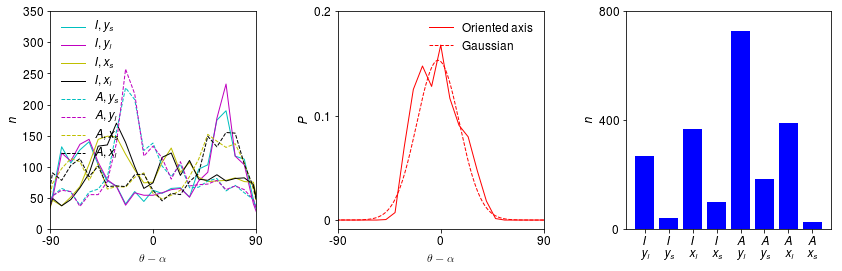

In [307]:
# figure of the histograms of the orientation theory vs data

fs = 12
S = 10
LW = 1

fig = plt.gcf()

# histograms of each of the 8 options
ax2 = plt.subplot(131)

sc1 = ax2.plot(thetabinmids*180/np.pi,bedjshist,'c',lw=LW,label='$I,y_s$')
sc1 = ax2.plot(thetabinmids*180/np.pi,bedjlhist,'m',lw=LW,label='$I,y_l$')
sc1 = ax2.plot(thetabinmids*180/np.pi,bedishist,'y',lw=LW,label='$I,x_s$')
sc1 = ax2.plot(thetabinmids*180/np.pi,bedilhist,'k',lw=LW,label='$I,x_l$')
sc1 = ax2.plot(thetabinmids*180/np.pi,finjshist,'--c',lw=LW,label='$A,y_s$')
sc1 = ax2.plot(thetabinmids*180/np.pi,finjlhist,'--m',lw=LW,label='$A,y_l$')
sc1 = ax2.plot(thetabinmids*180/np.pi,finishist,'--y',lw=LW,label='$A,x_s$')
sc1 = ax2.plot(thetabinmids*180/np.pi,finilhist,'--k',lw=LW,label='$A,x_l$')

ax2.set_xlabel('$\\theta-\\alpha$', fontsize=fs)
ax2.set_ylabel('$n$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

l = ax2.legend(loc=2,frameon=False,fontsize=fs)

plt.xlim(-90,-90)
plt.ylim(0,350)

plt.xticks(np.linspace(-90,90,3), ('-90', '0', '90'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# histogram of the 'best fits' with its gaussian too
ax2 = plt.subplot(132)

sc1 = ax2.plot(thetabinmids*180/np.pi,bestahist/np.sum(bestahist),'r',lw=LW,label='Oriented axis')
sc1 = ax2.plot(gausx*180/np.pi,bestagaus/360*45,'--r',lw=LW,label='Gaussian')

ax2.set_xlabel('$\\theta-\\alpha$', fontsize=fs)
ax2.set_ylabel('$P$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

l = ax2.legend(loc=0,frameon=False,fontsize=fs)

plt.xlim(-90,90)

plt.xticks(np.linspace(-90,90,3), ('-90', '0', '90'))
plt.yticks(np.linspace(0,0.2,3), ('0', '0.1', '0.2'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# probability bar chart of the occurence of the 8 different types
ax2 = plt.subplot(133)

sc1 = ax2.bar(comboabinmids,comboahist,color='b',align='center')

ax2.set_xlabel('', fontsize=fs)
ax2.set_ylabel('$n$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(np.linspace(0,7,8), ('$I$\n$y_l$','$I$\n$y_s$','$I$\n$x_l$','$I$\n$x_s$','$A$\n$y_l$','$A$\n$y_s$','$A$\n$x_l$','$A$\n$x_s$'))
plt.yticks(np.linspace(0,800,3), ('0', '400', '800'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(14, 4, forward=True)
fig.savefig('/home/andrew/Desktop/orientationpredictions.png',dpi=300)

In [354]:
# make arrays of the geometries sorted by if the bed or finger mode theory fits the observations best
# done for wavelength, width and defect ratio 
# you might expect the defect ratio to be higher for the bed instability

finI = np.squeeze(np.vstack((Il_M[np.argwhere(bestfitarg==4)],
                             Il_M[np.argwhere(bestfitarg==6)],
                             Is_M[np.argwhere(bestfitarg==5)],
                             Is_M[np.argwhere(bestfitarg==7)])))
finJ = np.squeeze(np.vstack((Jl_M[np.argwhere(bestfitarg==4)],
                             Jl_M[np.argwhere(bestfitarg==6)],
                             Js_M[np.argwhere(bestfitarg==5)],
                             Js_M[np.argwhere(bestfitarg==7)])))
finDRa = np.squeeze(np.vstack((DRal[np.argwhere(bestfitarg==4)],
                               DRal[np.argwhere(bestfitarg==6)],
                               DRas[np.argwhere(bestfitarg==5)],
                               DRas[np.argwhere(bestfitarg==7)])))

bedI = np.squeeze(np.vstack((Il_M[np.argwhere(bestfitarg==0)],
                             Il_M[np.argwhere(bestfitarg==2)],
                             Is_M[np.argwhere(bestfitarg==1)],
                             Is_M[np.argwhere(bestfitarg==3)])))
bedJ = np.squeeze(np.vstack((Jl_M[np.argwhere(bestfitarg==0)],
                             Jl_M[np.argwhere(bestfitarg==2)],
                             Js_M[np.argwhere(bestfitarg==1)],
                             Js_M[np.argwhere(bestfitarg==3)])))
bedDRa = np.squeeze(np.vstack((DRal[np.argwhere(bestfitarg==0)],
                               DRal[np.argwhere(bestfitarg==2)],
                               DRas[np.argwhere(bestfitarg==1)],
                               DRas[np.argwhere(bestfitarg==3)]))) 

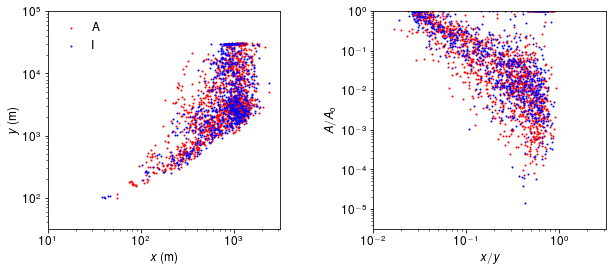

In [308]:
# geometry figures sorted by bed or finger mode

fs = 12
LW = 1
S = 1

S1 = 50

fig = plt.gcf()

ax2 = plt.subplot(121)

sc2 = ax2.scatter(finI,finJ,c='r',s=S,label='A')
sc2 = ax2.scatter(bedI,bedJ,c='b',s=S,label='I')

ax2.set_xlabel('$x$ (m)', fontsize=fs)
ax2.set_ylabel('$y$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**1,10**3.5)
plt.ylim(10**1.5,10**5)

ax2.set_xscale('log')
ax2.set_yscale('log')

l = ax2.legend(loc=0,frameon=False,fontsize=fs)

ax2 = plt.subplot(122)

sc2 = ax2.scatter(finI/finJ,finDRa,c='r',s=S)
sc2 = ax2.scatter(bedI/bedJ,bedDRa,c='b',s=S)

ax2.set_xlabel('$x/y$', fontsize=fs)
ax2.set_ylabel('$A/A_{0}$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-2,10**0.5)
plt.ylim(10**-5.5,10**0)

ax2.set_xscale('log')
ax2.set_yscale('log')

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(10, 4, forward=True)
fig.savefig('/home/andrew/Desktop/orientationgeoms.png',dpi=300)

# would expect the A-advective-finger mode to have lower A/A0 ratios than I-instability mode if they are circular
# since they should be seperated

In [355]:
# load age data from dune fields in the era5 set
# this is all luminesce data that is an age at a height 
# it's from this compilation http://www.dri.edu/data/320-programs/inqua-dunes-atlas
# i chose the data, organised by dune field, manually by looking at locations on google earth
# codes for the data are in a .txt, the codes link to the actualy data in the .kmz

text_file = open('/media/synology2/WANDS/ERA5/era_dune_inqua_ages.txt', 'r')
lines = text_file.readlines()
text_file.close()

# load IDs of the age data
ageids = []
ageid = ['']
for i in lines:
    if '\n'==i:
        ageids.append(ageid[1:])
        ageid = ['']
    else:
        ageid.append(i[:-1])
        
#parse the kmz
kmz = ZipFile('/media/synology2/WANDS/ERA5/inqua.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# random close pack - porosity for the exner equation
rcp = 0.64

lumages = []
lumerrs = []
lumzs   = []
lumfluxdivs = []

#--
lumduneareas = []

# loop through dunefields
for i in np.arange(0,np.shape(ageids)[0]):
    # saving the time, time-error, depth and flux divergence (by exner) of each of the data points
    lumage = []
    lumerr = []
    lumz   = []
    lumfluxdiv = []
    #--
    # also save the area of the dune field for each data point for plotting
    lumdunearea = []
    
    # loop through ages in that dunefield
    for j in np.arange(0,np.shape(ageids[i])[0]):
        if ageids[i][j]=='none':
            lumage.append(np.nan)
            lumerr.append(np.nan)
            lumz.append(np.nan) 
        else:
            lumage.append(float(handler.mapping[ageids[i][j]]["description"].split("LUMAGE:</b> ")[1].split("<br>")[0]))
            try:
                lumerr.append(float(handler.mapping[ageids[i][j]]["description"].split("LUMERR:</b> ")[1].split("<br>")[0]))
            except:
                lumerr.append(np.nan)
            try:
                if float(handler.mapping[ageids[i][j]]["description"].split("SAMPDEPTH:</b> ")[1].split("<br>")[0]) == -999:
                    lumz.append(np.nan)
                else:    
                    lumz.append(float(handler.mapping[ageids[i][j]]["description"].split("SAMPDEPTH:</b> ")[1].split("<br>")[0]))
            except:
                lumz.append(np.nan)
                
            try:
                lumfluxdiv.append(rcp*lumz[-1]/lumage[-1])
            except:
                lumfluxdiv.append(np.nan)
        #--
        lumdunearea.append(duneareas[i])
        
    lumages.append(lumage)
    lumerrs.append(lumerr)
    lumzs.append(lumz)
    lumfluxdivs.append(lumfluxdiv)
    lumduneareas.append(lumdunearea)

Lumduneareas = np.concatenate(lumduneareas)

In [356]:
# make arrays that are all the age data but an equally shaped array of the
# reciprocal of how many samples per dunefield there are for each sample
# this can be used in a histogram or kernel density estimate to account for sampling bias
# i.e. to ensure a 1 sample dune field is as important as a 10 same dune field

Lumzs = []
Lumages = []
Weights = []
for i in np.arange(0,np.shape(lumzs)[0]):
    lumzstemp = np.asarray(lumzs[i])
    lumagestemp = np.asarray(lumages[i])
    badones = [np.argwhere(np.isnan(lumzstemp)),np.argwhere(np.isnan(lumagestemp)),np.argwhere(lumzstemp==0),np.argwhere(lumagestemp==0)]
    badones = np.concatenate(badones)
    Lumages.append(np.delete(lumagestemp,badones))
    Lumzs.append(np.delete(lumzstemp,badones))
    weight = np.ones_like(np.delete(lumagestemp,badones))*1/np.shape(np.delete(lumagestemp,badones))[0]
    Weights.append(weight)
    
Lumzs = np.concatenate(Lumzs)
Lumages = np.concatenate(Lumages)
Weights = np.concatenate(Weights)

samples = np.vstack((Lumages,Lumzs))
weights = Weights

logsamples = np.log10(samples)

In [311]:
# make a kernel density estimate probability distribution of ages and depths

# renormalise the sample weights
weights /= np.sum(weights)

# places to sample the kde pdf
xmin, xmax = 0.5,6
ymin, ymax = -1.5,3
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
# evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)

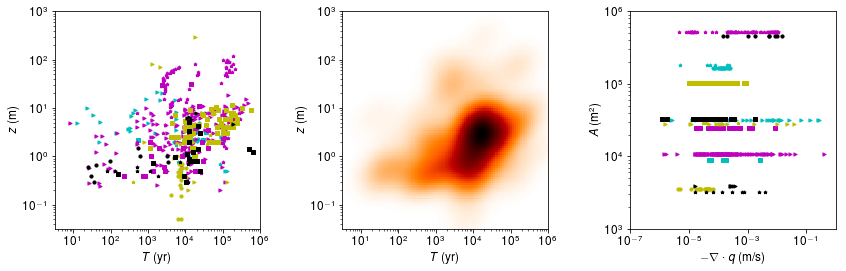

In [312]:
# figure on the age data
# there are only 16 dune fields with age data

fs = 12
S = 10
LW = 3

fig = plt.gcf()

# plot of data for age and depth, markers unique to each dune field
ax2 = plt.subplot(131)

# ones that aren't nan
goodinds = [0,2,7,8,9,11,13,21,26,27,28,30,31,32,35,36]

markers = ['>','*','o','s']
colors  = ['c','m','y','k']

for i in np.arange(0,np.shape(colors)[0]):
    for j in np.arange(0,np.shape(markers)[0]):
        sc1 = ax2.scatter(lumages[goodinds[i*4+j]],lumzs[goodinds[i*4+j]],s=S,c=colors[i],marker=markers[j])

ax2.set_xlabel('$T$ (yr)', fontsize=fs)
ax2.set_ylabel('$z$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0.5,10**6)
plt.ylim(10**-1.5,10**3)

# kde pdf of plot to left
ax2 = plt.subplot(132)

sc1 = ax2.pcolormesh(10**xx,10**yy,zz,cmap=palette)

ax2.set_xlabel('$T$ (yr)', fontsize=fs)
ax2.set_ylabel('$z$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0.5,10**6)
plt.ylim(10**-1.5,10**3)

# flux divergence vs dune field area
# not expected to fit

ax2 = plt.subplot(133)

for i in np.arange(0,np.shape(colors)[0]):
    for j in np.arange(0,np.shape(markers)[0]):
        sc1 = ax2.scatter(lumfluxdivs[goodinds[i*4+j]],lumduneareas[goodinds[i*4+j]],s=S,c=colors[i],marker=markers[j])

ax2.set_xlabel('$-\\nabla\\cdot q$ (m/s)', fontsize=fs)
ax2.set_ylabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-7,10**0)
plt.ylim([10**3,10**6])

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(14, 4, forward=True)
fig.savefig('/home/andrew/Desktop/inquadatainfo.png',dpi=300)

In [313]:
# get arrays and weights for the large geometry and flux divergences 

Lumflxs = []
Asterzs = []
Asteris = []
Weights = []

for i in np.arange(0,np.shape(lumzs)[0]):
    lumzstemp = np.asarray(lumzs[i])
    lumagestemp = np.asarray(lumages[i])
    badones = [np.argwhere(np.isnan(lumzstemp)),np.argwhere(np.isnan(lumagestemp)),np.argwhere(lumzstemp==0),np.argwhere(lumagestemp==0)]
    badones = np.concatenate(badones)
    lumflx = np.delete(rcp*lumzstemp/lumagestemp,badones)
    
    dunetiles = np.argwhere(tileindices[:,0]==i)
    
    lumflxs,asterzs = np.meshgrid(lumflx,Zl_M[dunetiles])
    _      ,asteris = np.meshgrid(lumflx,Il_M[dunetiles])
    
    Lumflxs.append(np.ndarray.flatten(lumflxs))
    Asterzs.append(np.ndarray.flatten(asterzs))
    Asteris.append(np.ndarray.flatten(asteris))
    
    weight     = np.empty_like(np.ndarray.flatten(lumflxs))
    weight[:]  = np.shape(weight)[0]
    Weights.append(weight)
    
Lumflxs = np.concatenate(Lumflxs)
Asterzs = np.concatenate(Asterzs)
Asteris = np.concatenate(Asteris)
Weights = 1/np.concatenate(Weights)

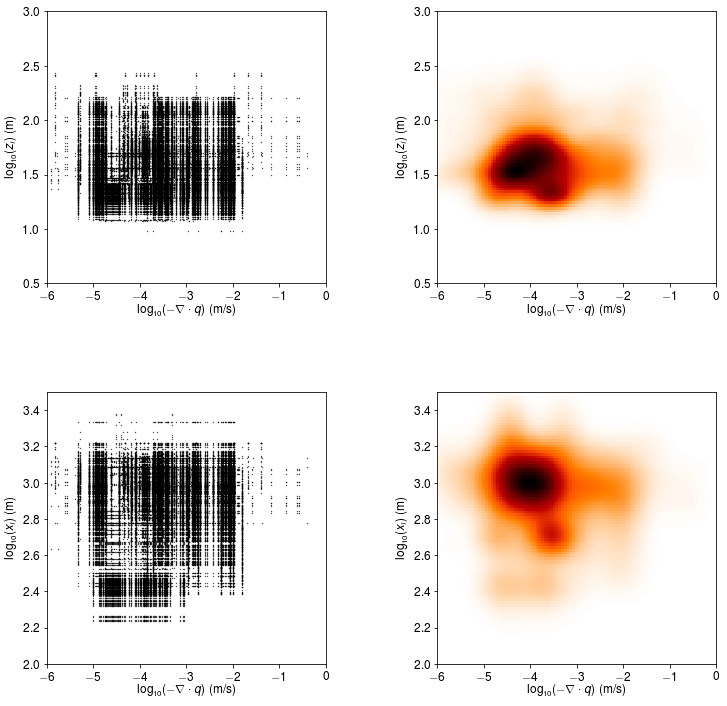

In [314]:
# figures of the raw data and kde pdfs of the small dune wavelengths and heights vs the flux divergences

fs = 12
S = 10
LW = 3

palette = copy(plt.get_cmap('gist_heat_r'))
palette.set_under('white', 1.0)

fig = plt.gcf()

###########
samples = np.vstack((Lumflxs,Asterzs))
logsamples = np.log10(samples)
weights = Weights
weights /= np.sum(weights)

xmin, xmax = -6,0
ymin, ymax = 0.5,3
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
#Evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)
###########

ax2 = plt.subplot(221)

sc1 = ax2.scatter(logsamples[0],logsamples[1],c='k',s=0.1)

ax2.set_xlabel('$\\log_{10}(-\\nabla\\cdot q)$ (m/s)', fontsize=fs)
ax2.set_ylabel('$\\log_{10}(z_l)$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

ax2 = plt.subplot(222)

sc1 = ax2.pcolormesh(xx,yy,zz,cmap=palette)

ax2.set_xlabel('$\\log_{10}(-\\nabla\\cdot q)$ (m/s)', fontsize=fs)
ax2.set_ylabel('$\\log_{10}(z_l)$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

###########
samples = np.vstack((Lumflxs,Asteris))
logsamples = np.log10(samples)
weights = Weights
weights /= np.sum(weights)

xmin, xmax = -6,0
ymin, ymax = 2,3.5
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
#Evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)
###########

ax2 = plt.subplot(223)

sc1 = ax2.scatter(logsamples[0],logsamples[1],c='k',s=0.1)

ax2.set_xlabel('$\\log_{10}(-\\nabla\\cdot q)$ (m/s)', fontsize=fs)
ax2.set_ylabel('$\\log_{10}(x_l)$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

ax2 = plt.subplot(224)

sc1 = ax2.pcolormesh(xx,yy,zz,cmap=palette)

ax2.set_xlabel('$\\log_{10}(-\\nabla\\cdot q)$ (m/s)', fontsize=fs)
ax2.set_ylabel('$\\log_{10}(x_l)$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(12, 12, forward=True)
fig.savefig('/home/andrew/Desktop/inquafluxdivgeom.png',dpi=300)

In [ ]:
# same as above but just age not flux divergence
# strong sampling biases here

Lumages = []
Asterzs = []
Asteris = []
Weights = []

for i in np.arange(0,np.shape(lumages)[0]):
    lumagestemp = np.asarray(lumages[i])
    badones = [np.argwhere(np.isnan(lumagestemp)),np.argwhere(lumagestemp==0)]
    badones = np.concatenate(badones)
    lumage = np.delete(lumagestemp,badones)
    
    dunetiles = np.argwhere(tileindices[:,0]==i)
    
    ages,asterzs = np.meshgrid(lumage,Zl_M[dunetiles])
    _      ,asteris = np.meshgrid(lumage,Il_M[dunetiles])
    
    Lumages.append(np.ndarray.flatten(ages))
    Asterzs.append(np.ndarray.flatten(asterzs))
    Asteris.append(np.ndarray.flatten(asteris))
    
    weight     = np.empty_like(np.ndarray.flatten(ages))
    weight[:]  = np.shape(weight)[0]
    Weights.append(weight)
    
Lumages = np.concatenate(Lumages)
Asterzs = np.concatenate(Asterzs)
Asteris = np.concatenate(Asteris)
Weights = 1/np.concatenate(Weights)

In [ ]:
# figures of the raw data and kde pdfs of the small dune wavelengths and heights vs the inqua ages
# strong sampling bias here for the age data

fs = 12
S = 10
LW = 3

palette = copy(plt.get_cmap('gist_heat_r'))
palette.set_under('white', 1.0)

fig = plt.gcf()

###########
samples = np.vstack((Lumages,Asterzs))
logsamples = np.log10(samples)
weights = Weights
weights /= np.sum(weights)

xmin, xmax = 0.5,6
ymin, ymax = 0.5,3
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
#Evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)
###########

ax2 = plt.subplot(221)

sc1 = ax2.scatter(samples[0],samples[1],c='k',s=0.1)

ax2.set_xlabel('$T$ (yr)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0.5,10**6)
plt.ylim(10**0.5,10**3)

ax2 = plt.subplot(222)

sc1 = ax2.pcolormesh(10**xx,10**yy,zz,cmap=palette)

ax2.set_xlabel('$T$ (yr)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0.5,10**6)
plt.ylim(10**0.5,10**3)

###########
samples = np.vstack((Lumages,Asteris))
logsamples = np.log10(samples)
weights = Weights
weights /= np.sum(weights)

xmin, xmax = 0.5,6
ymin, ymax = 2,3.5
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
#Evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)
###########

ax2 = plt.subplot(223)

sc1 = ax2.scatter(samples[0],samples[1],c='k',s=0.1)

ax2.set_xlabel('$T$ (yr)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0.5,10**6)
plt.ylim(10**2,10**3.5)

ax2 = plt.subplot(224)

sc1 = ax2.pcolormesh(10**xx,10**yy,zz,cmap=palette)

ax2.set_xlabel('$T$ (yr)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**0.5,10**6)
plt.ylim(10**2,10**3.5)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(12, 12, forward=True)
fig.savefig('/home/andrew/Desktop/inquaagesgeom.png',dpi=300)

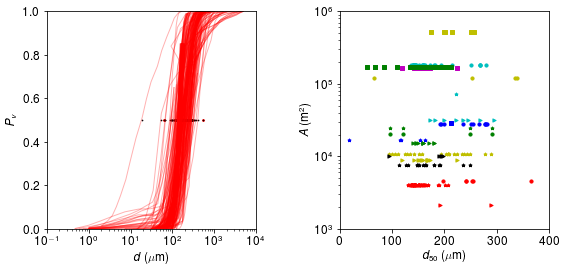

In [486]:
# figures of the grain size data

fs = 12
S = 10
LW = 3

fig = plt.gcf()

# subplot of all the distrubtions and their medians
ax2 = plt.subplot(121)

for i in np.arange(0,np.shape(distname)[0]):
    if np.shape(distsize[i])[0]>1:
        sc1 = ax2.plot(distsize[i]*1e+6,distperc[i]*1e-2,lw=1,c='r',alpha=0.3)
    else:
        sc1 = ax2.scatter(distsize[i]*1e+6,distperc[i]*1e-2,s=3,c='r')
        
sc1 = ax2.scatter(distmed*1e+6,np.ones_like(distmed)*0.5,s=0.5,c='k')
        
ax2.set_xlabel('$d$ ($\\mu$m)', fontsize=fs)
ax2.set_ylabel('$P_{v}$', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
plt.ylim(0,1)
plt.xlim(10**-1,10**4)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# subplot of the medians for a dune field vs the dune field age
# markers are unique to each dune field
ax2 = plt.subplot(122)

markers = ['>','*','o','s']
colors  = ['c','m','y','k','r','g','b']

for i in np.arange(0,np.shape(colors)[0]):
    for j in np.arange(0,np.shape(markers)[0]):
        temp = np.ones_like(distmedsbydf[i*4+j])*duneareas[i*4+j]
        sc1 = ax2.scatter(distmedsbydf[i*4+j]*1e+6,temp,s=S,c=colors[i],marker=markers[j])

ax2.set_xlabel('$d_{50}$ ($\\mu$m)', fontsize=fs)
ax2.set_ylabel('$A$ (m$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

# ax2.set_xscale('log')
ax2.set_yscale('log')

# plt.xlim(10**0,10**3)
plt.xlim(0,400)
plt.ylim([10**3,10**6])

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(9, 4, forward=True)
fig.savefig('/home/andrew/Desktop/graindist.png',dpi=300)

In [402]:
# arrays of the median grain sizes and large dune geometry and their weights for each dune field

Mediams = []
Asterzs = []
Asteris = []
Weights = []

for i in np.arange(0,np.shape(duneareas)[0]):
    dunetiles = np.argwhere(tileindices[:,0]==i)
    graindists = np.argwhere(np.asarray(distdf)==i)
    
    mediams,asterzs = np.meshgrid(distmed[graindists],Zl_M[dunetiles])
    _      ,asteris = np.meshgrid(distmed[graindists],Il_M[dunetiles])
    
    Mediams.append(np.ndarray.flatten(mediams))
    Asterzs.append(np.ndarray.flatten(asterzs))
    Asteris.append(np.ndarray.flatten(asteris))
    
    weight     = np.empty_like(np.ndarray.flatten(mediams))
    weight[:]  = np.shape(weight)[0]
    Weights.append(weight)
    
Mediams = np.concatenate(Mediams)
Asterzs = np.concatenate(Asterzs)
Asteris = np.concatenate(Asteris)
Weights = 1/np.concatenate(Weights)

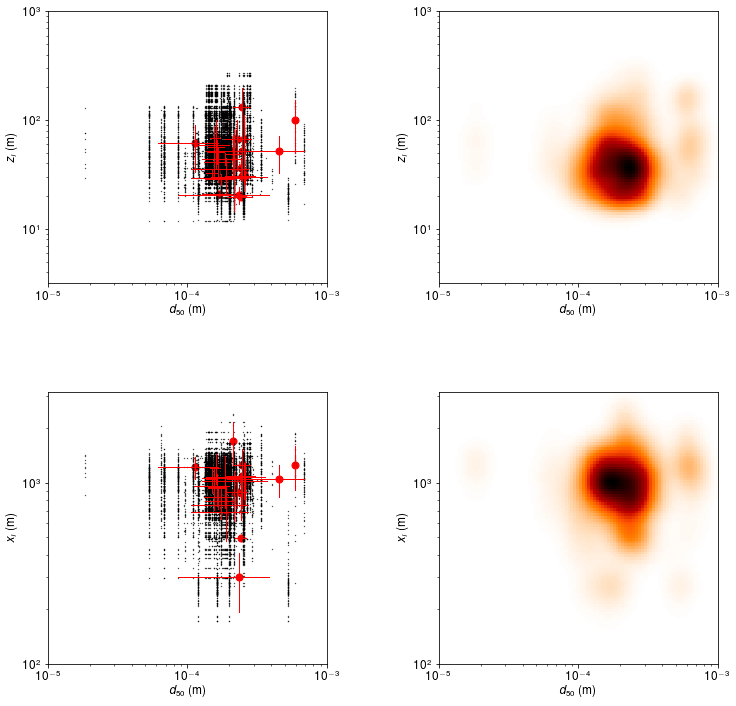

In [403]:
# plots of the grain size and dune geometry for each dune field

fs = 12
S = 10
LW = 1
S1 = 50

palette = copy(plt.get_cmap('gist_heat_r'))
palette.set_under('white', 1.0)

fig = plt.gcf()

###########
samples = np.vstack((Mediams,Asterzs))
logsamples = np.log10(samples)
weights = Weights
weights /= np.sum(weights)

xmin, xmax = -5,-3
ymin, ymax = 0.5,3
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
#Evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)
###########

# scatter plot of median grain size and large dune height
# with dune field means and standard deviations
ax2 = plt.subplot(221)

sc2 = ax2.scatter(d50_mean,zl_mean,c='r',s=S1)
sc3 = ax2.plot([d50_mean,d50_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([d50_mean+d50_vari**0.5,d50_mean-d50_vari**0.5], 
               [zl_mean,zl_mean],
               'r',lw=LW)

sc1 = ax2.scatter(samples[0],samples[1],c='k',s=0.1)

ax2.set_xlabel('$d_{50}$ (m)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-5,10**-3)
plt.ylim(10**0.5,10**3)

# kde pdf of the plot to the left
ax2 = plt.subplot(222)

sc1 = ax2.pcolormesh(10**xx,10**yy,zz,cmap=palette)

ax2.set_xlabel('$d_{50}$ (m)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-5,10**-3)
plt.ylim(10**0.5,10**3)

###########
samples = np.vstack((Mediams,Asteris))
logsamples = np.log10(samples)
weights = Weights
weights /= np.sum(weights)

xmin, xmax = -5,-3
ymin, ymax = 2,3.5
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)

xx, yy = np.meshgrid(x, y)
#Evaluate the kde on a grid
pdf = gaussian_kde(logsamples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)
###########

# scatter plot of median grain size and large dune wavelength
# with dune field means and standard deviations
ax2 = plt.subplot(223)

sc2 = ax2.scatter(d50_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([d50_mean,d50_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([d50_mean+d50_vari**0.5,d50_mean-d50_vari**0.5], 
               [il_mean,il_mean],
               'r',lw=LW)

sc1 = ax2.scatter(samples[0],samples[1],c='k',s=0.1)

ax2.set_xlabel('$d_{50}$ (m)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-5,10**-3)
plt.ylim(10**2,10**3.5)

#kde pdf of the plot to the left
ax2 = plt.subplot(224)

sc1 = ax2.pcolormesh(10**xx,10**yy,zz,cmap=palette)

ax2.set_xlabel('$d_{50}$ (m)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-5,10**-3)
plt.ylim(10**2,10**3.5)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(12, 12, forward=True)
# fig.savefig('/home/andrew/Desktop/graindiamgeom.png',dpi=300)

In [ ]:
# this cells finds the flux and orientation data for each cell given it could have the
# median grain size of the distributions found on its dune field

GQtot = [] # total volume flux
GPQ0  = [] # slope of the power-law for the flux distribution
GPQ1  = [] # scaling product of the flux distribution
GBEDA = [] # bed instability orientation
GFINA = [] # finger instability orientation

# loop through all the tiles
os.chdir("/media/synology2/WANDS/ERA5/dune_tiles1/")
for file in glob.glob("*.pkl"):
    with open(file, 'rb') as f:
         gridcells_era,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)
    
    # find the dune field the tile is on
    # this step ensures every tile is in the final list output, even if the grainsize data is absent
    for i in np.arange(0,np.shape(ondunes)[0]):
        if np.any(ondunes[i]==int(file[5:-4])):
            gQtot = []
            gPQ0  = []
            gPQ1  = []
            gBEDA = []
            gFINA = []
            
            # loop through the grain sizes for the dune field the tile is in
            for j in np.arange(0,np.shape(distmedsbydf[i])[0]):    
                q = flux(U,distmedsbydf[i][j])
                gQtot.append(np.sum(q))
                
                cnts,bins = np.histogram(q[q!=0],bins=100)
                binmids = bins[:-1]+np.diff(bins)/2
                logcnts = np.log(cnts)
                temp = np.polyfit(binmids[~np.isinf(logcnts)],logcnts[~np.isinf(logcnts)],deg=1)
                gPQ0.append(temp[0])
                gPQ1.append(temp[1])
                
                bedmode,finmode = duneangles(q,A)
                Tbedmax = np.max(bedmode)
                Tbed = T[np.argmax(bedmode)]
                Tfinnul = finmode[np.argmin((np.abs(finmode-0)))]
                Tfin = T[np.argmin((np.abs(finmode-0)))]

                gBEDA.append(Tbed)
                gFINA.append(Tfin)

            GQtot.append(gQtot)
            GPQ0.append(gPQ0)
            GPQ1.append(gPQ1)
            GBEDA.append(gBEDA)
            GFINA.append(gFINA)

In [598]:
# here deal with making comparison arrays for geometry and flux

# all these will be shaped DUNEFIELDxDISTRIBUTIONSxTILES
GQtotdf = [ [] for i in np.arange(0,np.shape(duneareas)[0]) ] # list of fluxes by dune field
GIl_Mdf = [ [] for i in np.arange(0,np.shape(duneareas)[0]) ] # list of large dune wavelengths
GZl_Mdf = [ [] for i in np.arange(0,np.shape(duneareas)[0]) ]
GIs_Mdf = [ [] for i in np.arange(0,np.shape(duneareas)[0]) ]
GZs_Mdf = [ [] for i in np.arange(0,np.shape(duneareas)[0]) ]

gIl_Mflat = []
gZl_Mflat = []
gIs_Mflat = []
gZs_Mflat = []
gdunearea = []

for i in np.arange(0,np.shape(GQtot)[0]):
    GQtotdf[tileindices[i][0]].append(GQtot[i])
    GIl_Mdf[tileindices[i][0]].append(np.ones_like(GQtot[i])*Il_M[i])
    GZl_Mdf[tileindices[i][0]].append(np.ones_like(GQtot[i])*Zl_M[i])
    GIs_Mdf[tileindices[i][0]].append(np.ones_like(GQtot[i])*Is_M[i])
    GZs_Mdf[tileindices[i][0]].append(np.ones_like(GQtot[i])*Zs_M[i])
    
    gIl_Mflat.append(np.ones_like(GQtot[i])*Il_M[i])
    gZl_Mflat.append(np.ones_like(GQtot[i])*Zl_M[i])
    gIs_Mflat.append(np.ones_like(GQtot[i])*Is_M[i])
    gZs_Mflat.append(np.ones_like(GQtot[i])*Zs_M[i])
    gdunearea.append(np.ones_like(GQtot[i])*duneareas[tileindices[i][0]])
    
GQtotflat = np.concatenate(GQtot)
GIl_Mflat = np.concatenate(gIl_Mflat)
GZl_Mflat = np.concatenate(gZl_Mflat)
GIs_Mflat = np.concatenate(gIs_Mflat)
GZs_Mflat = np.concatenate(gZs_Mflat)
Gdunearea = np.concatenate(gdunearea)

GQtot_mean = np.empty(np.shape(duneareas)[0])
GQtot_vari = np.empty(np.shape(duneareas)[0])
GQtot_medi = np.empty(np.shape(duneareas)[0])

# find the mean, variance and median flux for each dune field
# this is slightly different to the 300 micron case since we're now
# finding them over the spread of era5 tiles AND grain size distributions
for i in np.arange(0,np.shape(duneareas)[0]):
    GQtot_mean[i] = np.mean(GQtotdf[i])
    GQtot_vari[i] = np.var(GQtotdf[i])
    GQtot_medi[i] = np.median(GQtotdf[i])
    
# total dune field scale fluxes
GQtot_ascaled_mean = GQtot_mean*duneareas/tilearea
GQtot_ascaled_vari = GQtot_vari*duneareas/tilearea
GQtot_ascaled_medi = GQtot_medi*duneareas/tilearea

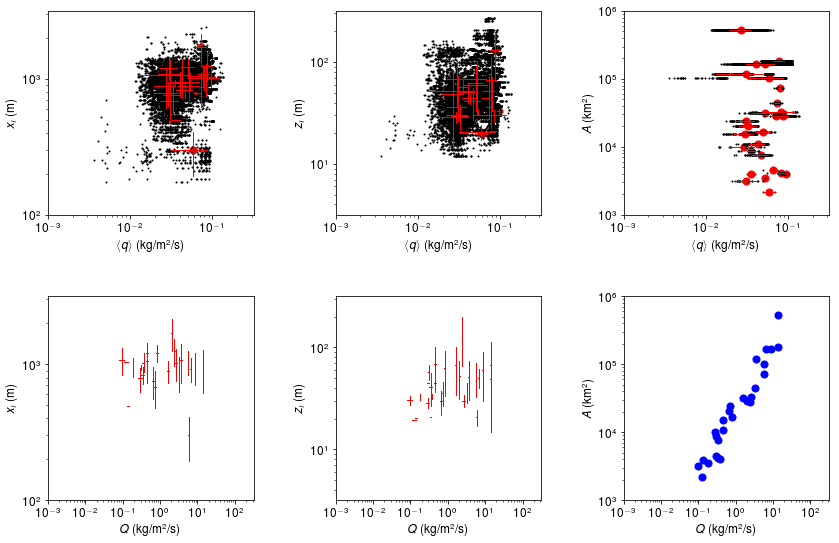

In [605]:
# figure of the flux - geometry and area relationships

fs = 12
S = 1
LW = 1

fig = plt.gcf()

# scatter of tile flux vs wavelength
# mean and standard deviation error bars for each dune field shown too
ax2 = plt.subplot(231)

sc2 = ax2.scatter(GQtot_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([GQtot_mean,GQtot_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([GQtot_mean+GQtot_vari**0.5,GQtot_mean-GQtot_vari**0.5], 
               [il_mean,il_mean],
               'r',lw=LW)

sc1 = ax2.scatter(GQtotflat, GIl_Mflat, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-3,10**-0.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# scatter of tile flux vs height
# mean and standard deviation error bars for each dune field shown too
ax2 = plt.subplot(232)

sc2 = ax2.scatter(GQtot_mean,zl_mean,c='r',s=S1)
sc3 = ax2.plot([GQtot_mean,GQtot_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([GQtot_mean+GQtot_vari**0.5,GQtot_mean-GQtot_vari**0.5], 
               [zl_mean,zl_mean],
               'r',lw=LW)

sc1 = ax2.scatter(GQtotflat, GZl_Mflat, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-3,10**-0.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# scatter of tile flux vs dune field area
# mean and standard deviation error bars for each dune field shown too
ax2 = plt.subplot(233)

sc2 = ax2.scatter(GQtot_mean,duneareas,c='r',s=S1)

sc4 = ax2.plot([GQtot_mean+GQtot_vari**0.5,GQtot_mean-GQtot_vari**0.5], 
               [duneareas,duneareas],
               'r',lw=LW)

sc1 = ax2.scatter(GQtotflat, Gdunearea, c='k',s=S)

ax2.set_xlabel('$\\langle q \\rangle$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$A$ (km$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-3,10**-0.5)
plt.ylim(10**3,10**6)

ax2.set_xscale('log')
ax2.set_yscale('log')

# scatter of dune field total flux vs wavelength
# mean and standard deviation error bars for each dune field shown too
ax2 = plt.subplot(234)

# sc2 = ax2.scatter(GQtot_ascaled_mean,il_mean,c='r',s=S1)
sc3 = ax2.plot([GQtot_ascaled_mean,GQtot_ascaled_mean], 
               [il_mean-il_vari**0.5,il_mean+il_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([GQtot_ascaled_mean+GQtot_ascaled_vari**0.5,GQtot_ascaled_mean-GQtot_ascaled_vari**0.5], 
               [il_mean,il_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$x_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-3,10**2.5)
plt.ylim(10**2,10**3.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# scatter of dune field total flux vs height
# mean and standard deviation error bars for each dune field shown too
ax2 = plt.subplot(235)

# sc2 = ax2.scatter(GQtot_ascaled_mean,zl_mean,c='r',s=S1)
sc3 = ax2.plot([GQtot_ascaled_mean,GQtot_ascaled_mean], 
               [zl_mean-zl_vari**0.5,zl_mean+zl_vari**0.5],
               'r',lw=LW)
sc4 = ax2.plot([GQtot_ascaled_mean+GQtot_ascaled_vari**0.5,GQtot_ascaled_mean-GQtot_ascaled_vari**0.5], 
               [zl_mean,zl_mean],
               'r',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$z_l$ (m)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-3,10**2.5)
plt.ylim(10**0.5,10**2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')

# scatter of dune field total flux vs area
# mean and standard deviation error bars for each dune field shown too
# this is autocorrelated since the total flux is the av tile flux scaled by a ratio of dune field area to tile area
ax2 = plt.subplot(236)

sc2 = ax2.scatter(GQtot_ascaled_mean,duneareas,c='b',s=S1)
sc4 = ax2.plot([GQtot_ascaled_mean+GQtot_ascaled_vari**0.5,GQtot_ascaled_mean-GQtot_ascaled_vari**0.5], 
               [duneareas,duneareas],
               'b',lw=LW)

ax2.set_xlabel('$Q$ (kg/m$^{2}$/s)', fontsize=fs)
ax2.set_ylabel('$A$ (km$^{2}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(10**-3,10**2.5)
plt.ylim(10**3,10**6)

ax2.set_xscale('log')
ax2.set_yscale('log')

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(14, 9, forward=True)
fig.savefig('/home/andrew/Desktop/grainfluxgeom.png',dpi=300)